### libraries

In [1]:
# Import standard libraries 
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
from scipy.stats import bernoulli, binom
import seaborn as sns
from scipy import stats as stat
import pylab 
from tueplots import axes, bundles , figsizes, fonts,fontsizes
from matplotlib.lines import Line2D
from imblearn.combine import SMOTEENN

In [2]:
# Import libraries for LR
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

In [3]:
from sklearn import tree          
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics
# Import libraries 
from sklearn import tree          
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
# Import libraries
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import graphviz  

In [4]:
import torch
from torch import nn
from torch.utils.data import  DataLoader,SubsetRandomSampler 
import torch.optim as optim # Optimization package
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

In [5]:
from xgboost import XGBClassifier

# Helper functions for model training

In [6]:
# function that returns dataset with propensity scores and propensity logits from logistic regression
def propensity_score_funct(dataset,model):
    # Generate propensity score prediction 
    probabilities = model.predict_proba(dataset.drop('treat', axis=1))
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities[1] # propensity score 
    # merge prediction and existing dataset 
    dataset_proba = pd.merge(dataset, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={1:'propensity_score'}, inplace = True) # rename column
    
    #dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    dataset_proba['propensity_logit'] = pd.DataFrame(np.nan_to_num(np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score'])),posinf=0,neginf=0))
    


In [7]:
resample=SMOTEENN(random_state=0)
# KFold cross validation 
def kfold_evaluation_SMOTEENN(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		predicted_proba = model.predict_proba(X_test)
		prediction_proba_df = pd.DataFrame(predicted_proba)
		pos_predicted_proba = prediction_proba_df[1] # Take positive probability predictions for ROC_AUC score  
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, pos_predicted_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['log-loss:', fold] = metrics.log_loss(y_test, predicted_proba)
	
	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)
		X_train , X_test, y_train , y_test = features.iloc[train_index,:],features.iloc[test_index,:],\
			                                 target[train_index] , target[test_index]
											 
		X_train, y_train = resample.fit_resample(X_train, y_train)	
		shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
		#resplit into test and train 
		X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 

# 1 - Load data sets 

In [8]:
'''
Load all datasets.
nsw = Male sub sample of treated and control units as used by Lalonde (1986).
nswre74  = Further subsample extracted by Dehejia and Wahba (1999) which includes information on earnings in 1974 (re74)

cps1 = full Current Population Survey dataset
cps2 , cps3 and cps4 are further subsamples exctracted by lalonde to with distributions which better match the nsw treated group.

psid1 = full Panel Study of Income Dynamics dataset
psid2,psid3,psid4 are again subsamples extracted by Lalonde 

'''
# experimental data 

nsw = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/nsw.dta")
nsw.drop('data_id', axis=1, inplace=True)
nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/nswre74_control.xls')
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/nswre74_treated.xlsx')
nswre74 = pd.concat([nswre74_control,nswre74_treated],axis=0,ignore_index=True) #Combine treatment into a single control as pandas dataframe

# non experimental data (cps)

cps = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/cps_controls.dta")
cps.drop('data_id', axis=1, inplace=True)

#cps['treat'] == 0 # created treated column
#load non experimental data (psid)

psid = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/psid_controls.dta")
psid.drop('data_id', axis=1, inplace=True)

# reset indexes

nsw = nsw.reset_index(drop=True)
nswre74 = nswre74.reset_index(drop=True)
cps = cps.reset_index(drop=True)
psid = psid.reset_index(drop=True)

# PS estimation helper functions

In [9]:
def propensity_score_funct(dataset,model,dataset2,dehwab):
    
    dataset2.columns = dataset2.columns.str.strip() 
    
    if dehwab == True: 
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re74','re75','re78']]
    else:
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re75','re78']]

    treat =  dataset.iloc[:,0]
    dataset =  dataset.iloc[:,1:len(dataset)]

    probabilities = model.predict_proba(dataset)
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities[1]  # propensity score 

    dataset_proba = pd.merge(dataset2, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={1:'propensity_score'}, inplace = True) # rename column
    dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    return dataset_proba

In [10]:
resample=SMOTEENN(random_state=0)
# KFold cross validation 
def kfold_evaluation_SMOTEENN(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		predicted_proba = model.predict_proba(X_test)
		prediction_proba_df = pd.DataFrame(predicted_proba)
		pos_predicted_proba = prediction_proba_df[1] # Take positive probability predictions for ROC_AUC score  
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, pos_predicted_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['log-loss:', fold] = metrics.log_loss(y_test, predicted_proba)
	

	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)
		X_train , X_test, y_train , y_test = features.iloc[train_index,:],features.iloc[test_index,:],\
			                                 target[train_index] , target[test_index]
											 
		X_train, y_train = resample.fit_resample(X_train, y_train)	
		shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
		#resplit into test and train 
		X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 

# 2. Propensity score estimation

In [11]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

### PS specs

In [12]:
ps_specification_logit_1 = ['treat','education*','black','hispanic','married','married_u75','nodegree','re75']
ps_specification_logit_2 = ['treat','age','education*','black','married','hispanic','black_education','hisp_re75','nodegree','re75']
ps_specification_logit_3 = ['treat','age','education*','black','hispanic','nodegree','black_age','married','re74','re75']
ps_specification_logit_4 = ['treat','age','education*','black','married','hispanic','married_u75','nodegree','re74','re75']

In [13]:
markov_blanket_specification_1 = ['treat','age','education*','black','married','nodegree','re75']# CPS Lalonde sample 
markov_blanket_specification_2 = ['treat','age','education*','married','nodegree','re75']# PSID Lalonde sample  
markov_blanket_specification_3 = ['treat','age','education*','black','married','re74','re75'] # CPS Dehwab sample
markov_blanket_specification_4 = ['treat','age','education*','married','nodegree','re74','re75'] # PSID Dehwab and wahba sample 

In [14]:
annSpecification_1 = ['treat','ageboxcox','education*','black','married','nodegree','re75'] # CPS Lalonde sample 
annSpecification_2 = ['treat','ageboxcox','education*','married','nodegree','re75']# PSID Lalonde sample  
annSpecification_3 = ['treat','ageboxcox','education*','black','married','re74','re75'] # CPS Dehwab sample
annSpecification_4 = ['treat','ageboxcox','education*','married','nodegree','re74','re75'] # PSID Dehwab and wahba sample 
nsw_continuos_vars1 = ['ageboxcox','re75'] 
nsw_continuos_vars2 = ['ageboxcox','re75'] 
nswre74_continuos_vars1 = ['ageboxcox','re75',] 
nswre74_continuos_vars2 = ['ageboxcox','re74','re75',] 

### model (1) Logistic Regression 

### Data

In [15]:
# Select covariates for use in Logit model 

# ======== Lalonde (1986) data ======== #

nswCps_lalonde_subset = nswCps_lalonde[ps_specification_logit_1]
nswPsid_lalonde_subset = nswPsid_lalonde[ps_specification_logit_2]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

nswCps_dehWab_subset = nswCps_dehWab[ps_specification_logit_3]
nswPsid_dehWab_subset = nswPsid_dehWab[ps_specification_logit_4]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)

### Validation

In [16]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics

# KFold cross validation 
def kfold_evaluation(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		predicted_proba = model.predict_proba(X_test)
		prediction_proba_df = pd.DataFrame(predicted_proba)
		pos_predicted_proba = prediction_proba_df[1] # Take positive probability predictions for ROC_AUC score  
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, pos_predicted_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['log-loss:', fold] = metrics.log_loss(y_test, predicted_proba)
		

	#Kfold training loop
	
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)
		X_train , X_test, y_train , y_test = features.iloc[train_index,:],features.iloc[test_index,:],\
			                                 target[train_index] , target[test_index]
											 
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 


In [17]:
from sklearn.linear_model import LogisticRegression
# dataframes to store resutls 
logit1_metrics = pd.DataFrame()
logit2_metrics = pd.DataFrame()
logit3_metrics = pd.DataFrame()
logit4_metrics = pd.DataFrame()
#models 
logit1 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit2 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit3 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit4 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)


In [18]:
# Model validation - K fold 
# ======== Lalonde (1986) sample ======== #
kfold_evaluation(logit1,nswCps_lalonde_features,nswCps_lalonde_target,logit1_metrics) # cps
kfold_evaluation(logit2,nswPsid_lalonde_features,nswPsid_lalonde_target,logit2_metrics) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
kfold_evaluation(logit3,nswCps_dehWab_features,nswCps_dehWab_target,logit3_metrics) # cps
kfold_evaluation(logit4,nswPsid_dehWab_features,nswPsid_dehWab_target,logit4_metrics) # psid

In [19]:
logit1_metrics['avg'] = np.mean(logit1_metrics,axis=1)
logit2_metrics['avg'] = np.mean(logit2_metrics,axis=1)
logit3_metrics['avg'] = np.mean(logit3_metrics,axis=1)
logit4_metrics['avg'] = np.mean(logit4_metrics,axis=1)

In [20]:
logit1_metrics

,0,1,2,3,4,avg
Accuracy:,0.888868,0.864759,0.861991,0.900891,0.892650,0.881832
Precision:,0.121348,0.130890,0.112360,0.129496,0.096552,0.118129
Recall:,0.900000,0.833333,0.847458,0.915254,0.949153,0.889040
MSE:,0.121854,0.104972,0.124002,0.112953,0.161805,0.125117
MAE:,0.121854,0.104972,0.124002,0.112953,0.161805,0.125117
R^2:,-5.740807,-4.806942,-5.973747,-5.352324,-8.096994,-5.994163
auc:,0.888868,0.864759,0.861991,0.900891,0.892650,0.881832
roc_auc:,0.962044,0.947871,0.945158,0.959619,0.964756,0.955889
F1:,0.213861,0.226244,0.198413,0.226891,0.175274,0.208137
log-loss:,0.263571,0.241323,0.262708,0.270125,0.337827,0.275111


In [21]:
logit1.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [22]:
logit2_metrics

,0,1,2,3,4,avg
Accuracy:,0.869779,0.913855,0.862603,0.904976,0.917790,0.893801
Precision:,0.481132,0.600000,0.521739,0.546392,0.467213,0.523295
Recall:,0.850000,0.900000,0.813559,0.898305,0.966102,0.885593
MSE:,0.114695,0.075269,0.098743,0.089767,0.120287,0.099752
MAE:,0.114695,0.075269,0.098743,0.089767,0.120287,0.099752
R^2:,-0.195181,0.215663,-0.042645,0.052141,-0.270131,-0.048031
auc:,0.869779,0.913855,0.862603,0.904976,0.917790,0.893801
roc_auc:,0.960793,0.972122,0.951603,0.972262,0.974032,0.966162
F1:,0.614458,0.720000,0.635762,0.679487,0.629834,0.655908
log-loss:,0.250577,0.200025,0.241414,0.204177,0.283941,0.236027


In [23]:
logit2.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [24]:
logit3_metrics

,0,1,2,3,4,avg
Accuracy:,0.879603,0.878040,0.875767,0.893413,0.936143,0.892593
Precision:,0.086486,0.084211,0.100977,0.089431,0.100559,0.092333
Recall:,0.864865,0.864865,0.837838,0.891892,0.972973,0.886486
MSE:,0.105995,0.109085,0.087172,0.105100,0.099845,0.101440
MAE:,0.105995,0.109085,0.087172,0.105100,0.099845,0.101440
R^2:,-8.377491,-8.650888,-6.709802,-8.295506,-7.830730,-7.972883
auc:,0.879603,0.878040,0.875767,0.893413,0.936143,0.892593
roc_auc:,0.961863,0.948616,0.969677,0.953949,0.983055,0.963432
F1:,0.157248,0.153477,0.180233,0.162562,0.182278,0.167160
log-loss:,0.233103,0.260611,0.213819,0.247897,0.239693,0.239025


In [25]:
logit3.get_params

<bound method BaseEstimator.get_params of LogisticRegression(class_weight='balanced', max_iter=500, penalty='none',
                   random_state=0)>

In [26]:
logit4_metrics

,0,1,2,3,4,avg
Accuracy:,0.942310,0.897292,0.957831,0.885244,0.957831,0.928102
Precision:,0.450000,0.477612,0.468354,0.405063,0.468354,0.453877
Recall:,0.972973,0.864865,1.000000,0.864865,1.000000,0.940541
MSE:,0.084112,0.074766,0.078505,0.097196,0.078505,0.082617
MAE:,0.084112,0.074766,0.078505,0.097196,0.078505,0.082617
R^2:,-0.306578,-0.161402,-0.219472,-0.509823,-0.219472,-0.283350
auc:,0.942310,0.897292,0.957831,0.885244,0.957831,0.928102
roc_auc:,0.983122,0.962254,0.982036,0.949256,0.986215,0.972577
F1:,0.615385,0.615385,0.637931,0.551724,0.637931,0.611671
log-loss:,0.192810,0.177873,0.200565,0.260109,0.206918,0.207655


In [27]:
logit4.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Inference

In [28]:
# Fit Logistic Regression using sklearn
# ======== Lalonde (1986) sample ======== #
logit1.fit(nswCps_lalonde_features,nswCps_lalonde_target) # cps
logit2.fit(nswPsid_lalonde_features,nswPsid_lalonde_target) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
logit3.fit(nswCps_dehWab_features,nswCps_dehWab_target) # cps
logit4.fit(nswPsid_dehWab_features,nswPsid_dehWab_target) # psid

LogisticRegression(class_weight='balanced', max_iter=500, penalty='none',
                   random_state=0)

In [29]:
# Change logisistic regression to STAT's model implementation 

In [30]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
nswCps_lalonde_ps_LOGIT_withRe78 = propensity_score_funct(nswCps_lalonde_subset,logit1,nswCps_lalonde,False)
nswPsid_lalonde_ps_LOGIT_withRe78= propensity_score_funct(nswPsid_lalonde_subset,logit2,nswPsid_lalonde,False)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_LOGIT_withRe78 = propensity_score_funct(nswCps_dehWab_subset,logit3,nswCps_dehWab,True)
nswPsid_dehWab_ps_LOGIT_withRe78 = propensity_score_funct(nswPsid_dehWab_subset,logit4,nswPsid_dehWab,True)


# Export data

In [31]:
# save unmatched logit datasets 
nswCps_lalonde_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswCps_lalonde_ps_unmatched_LOGIT_FS1.csv')
nswPsid_lalonde_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswPsid_lalonde_ps_unmatched_LOGIT_FS1.csv')
nswCps_dehWab_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswCps_dehWab_ps_unmatched_LOGIT_FS1.csv')
nswPsid_dehWab_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswPsid_dehWab_ps_unmatched_LOGIT_FS1.csv')

### model (2) ; CART 

In [32]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling

nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

# CART - Feature selection

In [33]:
""" Select covariates for use in CART model - from GNN features """
# ======== Lalonde (1986) data ======== #
nswCps_lalonde_subset = nswCps_lalonde[markov_blanket_specification_1]
nswPsid_lalonde_subset = nswPsid_lalonde[markov_blanket_specification_2]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

# Apply selection

nswCps_dehWab_subset = nswCps_dehWab[markov_blanket_specification_3]
nswPsid_dehWab_subset = nswPsid_dehWab[markov_blanket_specification_4]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)


## Validation 

In [34]:
# Grid search 
tree_param = [{'criterion': ['entropy', 'gini'], 
               'max_depth': [1,2,3,4,5,6,7,8,9,10,None],
               'max_leaf_nodes':list(range(0, 100)),
              'min_samples_leaf': [2, 3, 4]}]



In [35]:
cart1_metrics = pd.DataFrame()
cart2_metrics = pd.DataFrame()
cart3_metrics = pd.DataFrame()
cart4_metrics = pd.DataFrame()

grid_search_cart1 = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 5,max_leaf_nodes = 12,min_samples_leaf = 2)
grid_search_cart2 = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 7,max_leaf_nodes = 10,min_samples_leaf = 2)
grid_search_cart3 = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 5,max_leaf_nodes = 10,min_samples_leaf = 2)
grid_search_cart4 = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 5,max_leaf_nodes = 10,min_samples_leaf = 2)

In [36]:
kfold_evaluation_SMOTEENN(grid_search_cart1,nswCps_lalonde_features,nswCps_lalonde_target,cart1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_cart2,nswPsid_lalonde_features,nswPsid_lalonde_target,cart2_metrics) # psid
kfold_evaluation_SMOTEENN(grid_search_cart3,nswCps_dehWab_features,nswCps_dehWab_target,cart3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_cart4,nswPsid_dehWab_features,nswPsid_dehWab_target,cart4_metrics) # psid

<p> model evaluation </p>

In [37]:
cart1_metrics['avg'] = np.mean(cart1_metrics,axis=1)
cart2_metrics['avg'] = np.mean(cart2_metrics,axis=1)
cart3_metrics['avg'] = np.mean(cart3_metrics,axis=1)
cart4_metrics['avg'] = np.mean(cart4_metrics,axis=1)

In [38]:
cart1_metrics

,0,1,2,3,4,avg
Accuracy:,0.828377,0.844575,0.811093,0.855063,0.861876,0.840197
Precision:,0.325397,0.328244,0.351852,0.278481,0.167857,0.290366
Recall:,0.683333,0.716667,0.644068,0.745763,0.796610,0.717288
MSE:,0.031921,0.032228,0.027931,0.039595,0.075223,0.041380
MAE:,0.031921,0.032228,0.027931,0.039595,0.075223,0.041380
R^2:,-0.765854,-0.782833,-0.570819,-1.226766,-3.229153,-1.315085
auc:,0.828377,0.844575,0.811093,0.855063,0.861876,0.840197
roc_auc:,0.912344,0.904073,0.934929,0.952414,0.950856,0.930923
F1:,0.440860,0.450262,0.455090,0.405530,0.277286,0.405806
log-loss:,0.203878,0.153560,0.163919,0.171362,0.270913,0.192726


In [39]:
cart2_metrics

,0,1,2,3,4,avg
Accuracy:,0.826205,0.878916,0.848104,0.916020,0.904414,0.874732
Precision:,0.573333,0.695652,0.484536,0.616279,0.504673,0.574895
Recall:,0.716667,0.800000,0.796610,0.898305,0.915254,0.825367
MSE:,0.087814,0.059140,0.111311,0.070018,0.104129,0.086482
MAE:,0.087814,0.059140,0.111311,0.070018,0.104129,0.086482
R^2:,0.084940,0.383735,-0.175345,0.260670,-0.099517,0.090896
auc:,0.826205,0.878916,0.848104,0.916020,0.904414,0.874732
roc_auc:,0.886044,0.932112,0.918930,0.952709,0.960724,0.930104
F1:,0.637037,0.744186,0.602564,0.731034,0.650602,0.673085
log-loss:,1.055793,0.325228,0.364697,0.233530,0.288515,0.453553


In [40]:
cart3_metrics

,0,1,2,3,4,avg
Accuracy:,0.907040,0.883055,0.891803,0.903753,0.922270,0.901584
Precision:,0.289720,0.173410,0.256410,0.242188,0.329897,0.258325
Recall:,0.837838,0.810811,0.810811,0.837838,0.864865,0.832432
MSE:,0.025340,0.046354,0.029057,0.031839,0.021638,0.030846
MAE:,0.025340,0.046354,0.029057,0.031839,0.021638,0.030846
R^2:,-1.241849,-3.100944,-1.569934,-1.815991,-0.913781,-1.728500
auc:,0.907040,0.883055,0.891803,0.903753,0.922270,0.901584
roc_auc:,0.946613,0.921542,0.931469,0.957871,0.974059,0.946311
F1:,0.430556,0.285714,0.389610,0.375758,0.477612,0.391850
log-loss:,0.107374,0.154577,0.108449,0.136092,0.108931,0.123084


In [41]:
cart4_metrics

,0,1,2,3,4,avg
Accuracy:,0.933355,0.874824,0.941848,0.860767,0.918376,0.905834
Precision:,0.566667,0.630435,0.530303,0.483333,0.695652,0.581278
Recall:,0.918919,0.783784,0.945946,0.783784,0.864865,0.859459
MSE:,0.054206,0.046729,0.061682,0.072897,0.035514,0.054206
MAE:,0.054206,0.046729,0.061682,0.072897,0.035514,0.054206
R^2:,0.157983,0.274124,0.041843,-0.132367,0.448334,0.157983
auc:,0.933355,0.874824,0.941848,0.860767,0.918376,0.905834
roc_auc:,0.976419,0.943721,0.979893,0.886356,0.925594,0.942397
F1:,0.701031,0.698795,0.679612,0.597938,0.771084,0.689692
log-loss:,0.200567,0.563904,0.612808,0.612825,0.417297,0.481480


### Inference

In [42]:
nswCps_lalonde_ps_CART_withRe78 = propensity_score_funct(nswCps_lalonde_subset,grid_search_cart1,nswCps_lalonde,False)
nswPsid_lalonde_ps_CART_withRe78= propensity_score_funct(nswPsid_lalonde_subset,grid_search_cart2,nswPsid_lalonde,False)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_CART_withRe78 = propensity_score_funct(nswCps_dehWab_subset,grid_search_cart3,nswCps_dehWab,True)
nswPsid_dehWab_ps_CART_withRe78 = propensity_score_funct(nswPsid_dehWab_subset,grid_search_cart4,nswPsid_dehWab,True)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [43]:
nswCps_dehWab_ps_CART_withRe78

,treat,age,education*,black,hispanic,married,nodegree,re74,re75,re78,propensity_score,propensity_logit
0,1.0,37,11,1.0,0.0,1.0,1.0,0,0,9930,0.913636,2.358866
1,1.0,22,9,0.0,1.0,0.0,1.0,0,0,3595,0.090841,-2.303411
2,1.0,30,12,1.0,0.0,0.0,0.0,0,0,24909,0.997095,5.838260
3,1.0,27,11,1.0,0.0,0.0,1.0,0,0,7506,0.997095,5.838260
4,1.0,33,8,1.0,0.0,0.0,1.0,0,0,289,0.997095,5.838260
...,...,...,...,...,...,...,...,...,...,...,...,...
16172,0.0,22,12,1.0,0.0,0.0,0.0,3975,6801,2757,0.973103,3.588482
16173,0.0,20,12,1.0,0.0,1.0,0.0,1445,11832,6895,0.204762,-1.356794
16174,0.0,37,12,0.0,0.0,0.0,0.0,1733,1559,4221,0.090841,-2.303411
16175,0.0,47,9,0.0,0.0,1.0,1.0,16914,11384,13671,0.000000,-inf


In [44]:
# save unmatched CART datasets 
nswCps_lalonde_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswCps_lalonde_ps_unmatched_CART_FS1.csv')
nswPsid_lalonde_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswPsid_lalonde_ps_unmatched_CART_FS1.csv')
nswCps_dehWab_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswCps_dehWab_ps_unmatched_CART_FS1.csv')
nswPsid_dehWab_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswPsid_dehWab_ps_unmatched_CART_FS1.csv')

### model (3) ; Random Forest

In [45]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78


In [46]:
""" Select covariates for use in CART model """
#sc = StandardScaler()
# ======== Lalonde (1986) data ======== #

nswCps_lalonde_subset = nswCps_lalonde[markov_blanket_specification_1]
nswPsid_lalonde_subset = nswPsid_lalonde[markov_blanket_specification_2]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

nswCps_dehWab_subset = nswCps_dehWab[markov_blanket_specification_3]
nswPsid_dehWab_subset = nswPsid_dehWab[markov_blanket_specification_4]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)

## Validation 

In [47]:
forest1_metrics = pd.DataFrame()
forest2_metrics = pd.DataFrame()
forest3_metrics = pd.DataFrame()
forest4_metrics = pd.DataFrame()

grid_search_forest1 = RandomForestClassifier(random_state=0,criterion = 'entropy',max_depth = 8,max_features = 'sqrt',min_samples_split = 2,n_estimators= 100)
grid_search_forest2 = RandomForestClassifier(random_state=0,criterion = 'gini',max_depth = 8,max_features = 'sqrt',min_samples_split = 2,n_estimators= 100)
grid_search_forest3 = RandomForestClassifier(random_state=0,criterion = 'entropy',max_depth = 8,max_features = 'log2',min_samples_split = 3,n_estimators= 500)
grid_search_forest4 = RandomForestClassifier(random_state=0,criterion = 'gini',max_depth = 8,max_features = 'log2',min_samples_leaf = 2,n_estimators= 500)

In [48]:
kfold_evaluation_SMOTEENN(grid_search_forest1,nswCps_lalonde_features,nswCps_lalonde_target,forest1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_forest2,nswPsid_lalonde_features,nswPsid_lalonde_target,forest2_metrics) # psid
kfold_evaluation_SMOTEENN(grid_search_forest3,nswCps_dehWab_features,nswCps_dehWab_target,forest3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_forest4,nswPsid_dehWab_features,nswPsid_dehWab_target,forest4_metrics) # psid

In [49]:
forest1_metrics['avg'] = np.mean(forest1_metrics,axis=1)
forest2_metrics['avg'] = np.mean(forest2_metrics,axis=1)
forest3_metrics['avg'] = np.mean(forest3_metrics,axis=1)
forest4_metrics['avg'] = np.mean(forest4_metrics,axis=1)

In [50]:
forest1_metrics

,0,1,2,3,4,avg
Accuracy:,0.835460,0.831348,0.812690,0.857877,0.920353,0.851545
Precision:,0.311111,0.383178,0.254902,0.314286,0.285714,0.309838
Recall:,0.700000,0.683333,0.661017,0.745763,0.881356,0.734294
MSE:,0.034070,0.026090,0.041130,0.034070,0.042063,0.035484
MAE:,0.034070,0.026090,0.041130,0.034070,0.042063,0.035484
R^2:,-0.884709,-0.443246,-1.313075,-0.916054,-1.364873,-0.984391
auc:,0.835460,0.831348,0.812690,0.857877,0.920353,0.851545
roc_auc:,0.937093,0.956087,0.934887,0.969506,0.979028,0.955320
F1:,0.430769,0.491018,0.367925,0.442211,0.431535,0.432692
log-loss:,0.124007,0.099098,0.123954,0.113170,0.122900,0.116626


In [51]:
forest2_metrics


,0,1,2,3,4,avg
Accuracy:,0.833233,0.881928,0.867181,0.890154,0.924495,0.879398
Precision:,0.632353,0.727273,0.602564,0.662162,0.620690,0.649008
Recall:,0.716667,0.800000,0.796610,0.830508,0.915254,0.811808
MSE:,0.075269,0.053763,0.077199,0.062837,0.068223,0.067458
MAE:,0.075269,0.053763,0.077199,0.062837,0.068223,0.067458
R^2:,0.215663,0.439759,0.184841,0.336499,0.279627,0.291278
auc:,0.833233,0.881928,0.867181,0.890154,0.924495,0.879398
roc_auc:,0.924916,0.960609,0.930502,0.967820,0.972075,0.951184
F1:,0.671875,0.761905,0.686131,0.736842,0.739726,0.719296
log-loss:,0.394292,0.222957,0.390829,0.185341,0.217657,0.282215


In [52]:
forest3_metrics

,0,1,2,3,4,avg
Accuracy:,0.885484,0.895402,0.858924,0.899464,0.925240,0.892903
Precision:,0.414286,0.319149,0.415385,0.441176,0.410256,0.400050
Recall:,0.783784,0.810811,0.729730,0.810811,0.864865,0.800000
MSE:,0.015142,0.021941,0.014838,0.013910,0.015765,0.016319
MAE:,0.015142,0.021941,0.014838,0.013910,0.015765,0.016319
R^2:,-0.339642,-0.941113,-0.312307,-0.230288,-0.394326,-0.443535
auc:,0.885484,0.895402,0.858924,0.899464,0.925240,0.892903
roc_auc:,0.981958,0.959628,0.986246,0.962084,0.988143,0.975612
F1:,0.542056,0.458015,0.529412,0.571429,0.556522,0.531487
log-loss:,0.056206,0.082109,0.047755,0.066157,0.061855,0.062817


In [53]:
forest4_metrics

,0,1,2,3,4,avg
Accuracy:,0.927874,0.877836,0.946869,0.879301,0.929882,0.912352
Precision:,0.647059,0.674419,0.573770,0.535714,0.673469,0.620886
Recall:,0.891892,0.783784,0.945946,0.810811,0.891892,0.864865
MSE:,0.041121,0.041121,0.052336,0.061682,0.037383,0.046729
MAE:,0.041121,0.041121,0.052336,0.061682,0.037383,0.046729
R^2:,0.361229,0.361229,0.187018,0.041843,0.419299,0.274124
auc:,0.927874,0.877836,0.946869,0.879301,0.929882,0.912352
roc_auc:,0.984099,0.960708,0.988549,0.917128,0.988549,0.967806
F1:,0.750000,0.725000,0.714286,0.645161,0.767442,0.720378
log-loss:,0.103740,0.151643,0.131280,0.355930,0.108682,0.170255


### Inference

In [54]:
#  Lalonde Subsample 
nswCps_lalonde_ps_FOREST_withRe78 = propensity_score_funct(nswCps_lalonde_subset,grid_search_forest1,nswCps_lalonde,False)
nswPsid_lalonde_ps_FOREST_withRe78= propensity_score_funct(nswPsid_lalonde_subset,grid_search_forest2,nswPsid_lalonde,False)
#  Dehejia & Wahba sub sample 
nswCps_dehWab_ps_FOREST_withRe78 = propensity_score_funct(nswCps_dehWab_subset,grid_search_forest3,nswCps_dehWab,True)
nswPsid_dehWab_ps_FOREST_withRe78 = propensity_score_funct(nswPsid_dehWab_subset,grid_search_forest4,nswPsid_dehWab,True)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [55]:
nswCps_dehWab_ps_FOREST_withRe78

,treat,age,education*,black,hispanic,married,nodegree,re74,re75,re78,propensity_score,propensity_logit
0,1.0,37,11,1.0,0.0,1.0,1.0,0,0,9930,0.908419,2.294488
1,1.0,22,9,0.0,1.0,0.0,1.0,0,0,3595,0.595480,0.386667
2,1.0,30,12,1.0,0.0,0.0,0.0,0,0,24909,0.993234,4.989093
3,1.0,27,11,1.0,0.0,0.0,1.0,0,0,7506,0.997318,5.918679
4,1.0,33,8,1.0,0.0,0.0,1.0,0,0,289,0.997181,5.868710
...,...,...,...,...,...,...,...,...,...,...,...,...
16172,0.0,22,12,1.0,0.0,0.0,0.0,3975,6801,2757,0.795504,1.358431
16173,0.0,20,12,1.0,0.0,1.0,0.0,1445,11832,6895,0.037091,-3.256592
16174,0.0,37,12,0.0,0.0,0.0,0.0,1733,1559,4221,0.016992,-4.057850
16175,0.0,47,9,0.0,0.0,1.0,1.0,16914,11384,13671,0.000190,-8.565793


In [56]:
# save unmatched logit datasets 
nswCps_lalonde_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/forest/unmatched/nswCps_lalonde_ps_unmatched_FOREST_FS1.csv')
nswPsid_lalonde_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/forest/unmatched/nswPsid_lalonde_ps_unmatched_FOREST_FS1.csv')
nswCps_dehWab_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/forest/unmatched/nswCps_dehWab_ps_unmatched_FOREST_FS1.csv')
nswPsid_dehWab_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/forest/unmatched/nswPsid_dehWab_ps_unmatched_FOREST_FS1.csv')

### model (4) ; Boosted Trees

In [57]:
""" Select covariates for use in BOOST model """
#sc = StandardScaler()
# ======== Lalonde (1986) data ======== #

# Apply selection
nswCps_lalonde_subset = nswCps_lalonde[markov_blanket_specification_1]
nswPsid_lalonde_subset = nswPsid_lalonde[markov_blanket_specification_2]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

# Apply selection
nswCps_dehWab_subset = nswCps_dehWab[markov_blanket_specification_3]
nswPsid_dehWab_subset = nswPsid_dehWab[markov_blanket_specification_4]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)



## Validation 

In [58]:
# dataframes to store results 
boost1_metrics = pd.DataFrame()
boost2_metrics = pd.DataFrame()
boost3_metrics = pd.DataFrame()
boost4_metrics = pd.DataFrame()
    

# models 
grid_search_boost1 = XGBClassifier(objective= 'binary:logistic',
                                    seed=0,
                                    booster = 'dart',
                                    colsample_bytree = 0.3,
                                    gamma = 0.5,
                                    learning_rate = 0.05,
                                    max_depth = None,
                                    min_child_weight = 2,
                                    subsample = 0.5,
                                    nthread=4) 
grid_search_boost2 = XGBClassifier(objective= 'binary:logistic',
                                    seed=0,
                                    booster = 'dart',
                                    colsample_bytree = 0.3,
                                    gamma = 0.5,
                                    learning_rate = 0.05,
                                    max_depth = None,
                                    min_child_weight = 2,
                                    subsample = 0.5,
                                    nthread=4) 
grid_search_boost3 = XGBClassifier(objective= 'binary:logistic',
                                    seed=0,
                                    booster = 'gbtree',
                                    colsample_bytree = 0.3,
                                    gamma = 1,
                                    learning_rate = 0.05,
                                    min_child_weight = 2,
                                    subsample = 0.5,
                                    nthread=4) 
grid_search_boost4 = XGBClassifier(objective= 'binary:logistic',
                                    seed=0,
                                    booster = 'gbtree',
                                    colsample_bytree = 0.3,
                                    gamma = 0.5,
                                    learning_rate = 0.05,
                                    min_child_weight = 2,
                                    subsample = 0.5,
                                    nthread=4) 

In [59]:
kfold_evaluation_SMOTEENN(grid_search_boost1,nswCps_lalonde_features,nswCps_lalonde_target,boost1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_boost2,nswPsid_lalonde_features,nswPsid_lalonde_target,boost2_metrics) # psid
kfold_evaluation_SMOTEENN(grid_search_boost3,nswCps_dehWab_features,nswCps_dehWab_target,boost3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_boost4,nswPsid_dehWab_features,nswPsid_dehWab_target,boost4_metrics) # psid

In [60]:
boost1_metrics['avg'] = np.mean(boost1_metrics,axis=1)
boost2_metrics['avg'] = np.mean(boost2_metrics,axis=1)
boost3_metrics['avg'] = np.mean(boost3_metrics,axis=1)
boost4_metrics['avg'] = np.mean(boost4_metrics,axis=1)

In [61]:
boost1_metrics

,0,1,2,3,4,avg
Accuracy:,0.851220,0.894199,0.843322,0.887971,0.924889,0.880320
Precision:,0.133333,0.205645,0.105727,0.152695,0.132867,0.146053
Recall:,0.800000,0.850000,0.813559,0.864407,0.966102,0.858814
MSE:,0.099448,0.063229,0.127993,0.089319,0.114830,0.098963
MAE:,0.099448,0.063229,0.127993,0.089319,0.114830,0.098963
R^2:,-4.501313,-2.497749,-6.198150,-4.023169,-5.455931,-4.535262
auc:,0.851220,0.894199,0.843322,0.887971,0.924889,0.880320
roc_auc:,0.943264,0.955910,0.926452,0.957691,0.965794,0.949822
F1:,0.228571,0.331169,0.187135,0.259542,0.233607,0.248005
log-loss:,0.226585,0.170982,0.252035,0.229116,0.259508,0.227645


In [62]:
boost2_metrics

,0,1,2,3,4,avg
Accuracy:,0.880823,0.915562,0.876098,0.897624,0.931404,0.900302
Precision:,0.536842,0.670886,0.556818,0.657895,0.565657,0.597620
Recall:,0.850000,0.883333,0.830508,0.847458,0.949153,0.872090
MSE:,0.094982,0.059140,0.087971,0.062837,0.082585,0.077503
MAE:,0.094982,0.059140,0.087971,0.062837,0.082585,0.077503
R^2:,0.010241,0.383735,0.071098,0.336499,0.127970,0.185908
auc:,0.880823,0.915562,0.876098,0.897624,0.931404,0.900302
roc_auc:,0.944478,0.969093,0.936628,0.967701,0.969880,0.957556
F1:,0.658065,0.762590,0.666667,0.740741,0.708861,0.707385
log-loss:,0.229203,0.184353,0.241779,0.198972,0.239462,0.218754


In [63]:
boost3_metrics

,0,1,2,3,4,avg
Accuracy:,0.909300,0.894452,0.898594,0.905384,0.938733,0.909293
Precision:,0.177778,0.116364,0.192547,0.156098,0.137795,0.156116
Recall:,0.864865,0.864865,0.837838,0.864865,0.945946,0.875676
MSE:,0.047281,0.076638,0.042040,0.055023,0.068315,0.057859
MAE:,0.047281,0.076638,0.042040,0.055023,0.068315,0.057859
R^2:,-3.182963,-5.780227,-2.718202,-3.866471,-5.042079,-4.117988
auc:,0.909300,0.894452,0.898594,0.905384,0.938733,0.909293
roc_auc:,0.976610,0.949676,0.981327,0.961517,0.986689,0.971164
F1:,0.294931,0.205128,0.313131,0.264463,0.240550,0.263641
log-loss:,0.150345,0.187916,0.143167,0.157134,0.174151,0.162542


In [64]:
boost4_metrics

,0,1,2,3,4,avg
Accuracy:,0.934820,0.887794,0.935824,0.873195,0.939840,0.914295
Precision:,0.479452,0.500000,0.486111,0.351648,0.514706,0.466383
Recall:,0.945946,0.837838,0.945946,0.864865,0.945946,0.908108
MSE:,0.074766,0.069159,0.072897,0.119626,0.065421,0.080374
MAE:,0.074766,0.069159,0.072897,0.119626,0.065421,0.080374
R^2:,-0.161402,-0.074297,-0.132367,-0.858244,-0.016227,-0.248508
auc:,0.934820,0.887794,0.935824,0.873195,0.939840,0.914295
roc_auc:,0.984641,0.959541,0.983773,0.922148,0.983149,0.966650
F1:,0.636364,0.626263,0.642202,0.500000,0.666667,0.614299
log-loss:,0.176870,0.174284,0.187314,0.259563,0.173311,0.194268


### Inference

In [65]:
#  Lalonde Subsample 
nswCps_lalonde_ps_BOOST_withRe78 = propensity_score_funct(nswCps_lalonde_subset,grid_search_boost1,nswCps_lalonde,False)
nswPsid_lalonde_ps_BOOST_withRe78= propensity_score_funct(nswPsid_lalonde_subset,grid_search_boost2,nswPsid_lalonde,False)
#  Dehejia & Wahba sub sample 
nswCps_dehWab_ps_BOOST_withRe78 = propensity_score_funct(nswCps_dehWab_subset,grid_search_forest3,nswCps_dehWab,True)
nswPsid_dehWab_ps_BOOST_withRe78 = propensity_score_funct(nswPsid_dehWab_subset,grid_search_forest4,nswPsid_dehWab,True)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [66]:
# save unmatched boost datasets 
nswCps_lalonde_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/boost/unmatched/nswCps_lalonde_ps_unmatched_BOOST_FS1.csv')
nswPsid_lalonde_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/boost/unmatched/nswPsid_lalonde_ps_unmatched_BOOST_FS1.csv')
nswCps_dehWab_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/boost/unmatched/nswCps_dehWab_ps_unmatched_BOOST_FS1.csv')
nswPsid_dehWab_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/boost/unmatched/nswPsid_dehWab_ps_unmatched_BOOST_FS1.csv')

In [67]:
nswPsid_lalonde_ps_BOOST_withRe78

,treat,age,education*,black,hispanic,married,nodegree,re75,re78,propensity_score,propensity_logit
0,1.0,37,11,1.0,0.0,1.0,1.0,0,9930,0.524682,0.098808
1,1.0,22,9,0.0,1.0,0.0,1.0,0,3595,0.925366,2.517594
2,1.0,30,12,1.0,0.0,0.0,0.0,0,24909,0.649052,0.614874
3,1.0,27,11,1.0,0.0,0.0,1.0,0,7506,0.917422,2.407825
4,1.0,33,8,1.0,0.0,0.0,1.0,0,289,0.751119,1.104587
...,...,...,...,...,...,...,...,...,...,...,...
2782,0.0,47,8,0.0,0.0,1.0,1.0,33837,38568,0.063609,-2.689278
2783,0.0,32,8,0.0,0.0,1.0,1.0,67137,59109,0.136257,-1.846732
2784,0.0,47,10,0.0,0.0,1.0,1.0,47968,55710,0.090488,-2.307686
2785,0.0,54,0,0.0,1.0,1.0,1.0,44220,20540,0.034184,-3.341218


### model (5) - artifical neural network

In [2]:
# Import libraries 
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import  DataLoader,SubsetRandomSampler 
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.model_selection import GridSearchCV
# Import standard libraries 
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
import seaborn as sns
from scipy import stats 
from psmpy.functions import cohenD
from psmpy.plotting import *
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTEENN


In [3]:
annSpecification_1 = ['treat','ageboxcox','education*','black','married','nodegree','re75'] # CPS Lalonde sample 
annSpecification_2 = ['treat','ageboxcox','education*','married','nodegree','re75']# PSID Lalonde sample  
annSpecification_3 = ['treat','ageboxcox','education*','black','married','re74','re75'] # CPS Dehwab sample
annSpecification_4 = ['treat','ageboxcox','education*','married','nodegree','re74','re75'] # PSID Dehwab and wahba sample 
nsw_continuos_vars1 = ['ageboxcox','re75'] 
nsw_continuos_vars2 = ['ageboxcox','re75'] 
nswre74_continuos_vars1 = ['ageboxcox','re75',] 
nswre74_continuos_vars2 = ['ageboxcox','re74','re75',] 

In [4]:
resample=SMOTEENN(random_state=0)
sm = SMOTE(random_state=0)

In [5]:
# Load quasi-experimental dataset

nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

In [6]:
# ANN data pre-processing
# Select covariates 
# ======== Lalonde (1986) data ======== #


nswCps_lalonde_subset = nswCps_lalonde[annSpecification_1]
nswPsid_lalonde_subset = nswPsid_lalonde[annSpecification_2]

# Z-score normalise continous variables
sc = MinMaxScaler()

nswCps_lalonde_subset[nsw_continuos_vars1] = sc.fit_transform(nswCps_lalonde_subset[nsw_continuos_vars1])
#nswPsid_lalonde_subset[nsw_continuos_vars2] = sc.fit_transform(nswPsid_lalonde_subset[nsw_continuos_vars2])

nswCps_lalonde_subset = nswCps_lalonde_subset.sample(frac=1).reset_index(drop=True)
nswPsid_lalonde_subset = nswPsid_lalonde_subset.sample(frac=1).reset_index(drop=True)

# Create targets and featues
nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #


nswCps_dehWab_subset = nswCps_dehWab[annSpecification_3]
nswPsid_dehWab_subset = nswPsid_dehWab[annSpecification_4]

nswCps_dehWab_subset[nswre74_continuos_vars1] = sc.fit_transform(nswCps_dehWab_subset[nswre74_continuos_vars1])
nswPsid_dehWab_subset[nswre74_continuos_vars2] = sc.fit_transform(nswPsid_dehWab_subset[nswre74_continuos_vars2])

nswCps_dehWab_subset = nswCps_dehWab_subset.sample(frac=1).reset_index(drop=True)
nswPsid_dehWab_subset = nswPsid_dehWab_subset.sample(frac=1).reset_index(drop=True)

# create targets and features 
nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)



/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_53989/3854445176.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nswCps_lalonde_subset[nsw_continuos_vars1] = sc.fit_transform(nswCps_lalonde_subset[nsw_continuos_vars1])
/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_53989/3854445176.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nswCps_dehWab_subset[nswre74_continuos_vars1] = sc.fit_transform(nswCps_dehWab_subset[nswre74_continuos_vars1])
/var/folders/sp/c9zy568j6s94zqs20ynd

### Inference

<p> Neural network </p>

In [7]:
# ANN model 
hid_1 = 12
hid_2 = 12

class twoLayerNN1(nn.Module):
    def __init__(self,num_features = nswCps_lalonde_features.shape[1], num_classes=1, num_hidden_1=hid_1, num_hidden_2=hid_2):
       
       
        super(twoLayerNN1, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        #self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
        #X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X

class twoLayerNN2(nn.Module):
    def __init__(self,num_features = nswPsid_lalonde_features.shape[1], num_classes=1, num_hidden_1=hid_1, num_hidden_2=hid_2):
       
        super(twoLayerNN2, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
        #X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X       

class twoLayerNN3(nn.Module):
    def __init__(self,num_features = nswCps_dehWab_features.shape[1], num_classes=1, num_hidden_1=hid_1, num_hidden_2=hid_2):
       
        super(twoLayerNN3, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
       # X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X       

class twoLayerNN4(nn.Module):
    def __init__(self,num_features = nswPsid_dehWab_features.shape[1], num_classes=1, num_hidden_1=hid_1, num_hidden_2=hid_2):
        super(twoLayerNN4, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
        #X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X       
   


### Model validation

In [8]:
from skorch import NeuralNetClassifier
Epochs = 50
learning_rate = 0.001
weight_decay = 0.0018
batch_size = 480

ANN1 = NeuralNetClassifier(twoLayerNN1,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size =batch_size,optimizer = optim.SGD,criterion = nn.BCELoss,iterator_valid__shuffle=False)
ANN2 = NeuralNetClassifier(twoLayerNN2,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size = batch_size,optimizer = optim.SGD,criterion = nn.BCELoss,iterator_valid__shuffle=False )
ANN3 = NeuralNetClassifier(twoLayerNN3,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size = batch_size,optimizer = optim.SGD,criterion = nn.BCELoss,iterator_valid__shuffle=False )
ANN4 = NeuralNetClassifier(twoLayerNN4,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size = batch_size,optimizer = optim.SGD,criterion = nn.BCELoss,iterator_valid__shuffle=False  )
                                                  
            

In [9]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics

# KFold cross validation 
def kfold_evaluation_ANN(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		prediction_proba = model.predict_proba(X_test)
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, prediction_proba)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, prediction_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['logloss:', fold] =  metrics.log_loss(y_test, prediction_proba)
	
	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)

		X_train , X_test, y_train , y_test = features[train_index],features[test_index],\
												target[train_index] , target[test_index]
		
		print('Xtrain pre augmentation:',X_train.shape)
		print('Ytrain pre augmentation',y_train.shape) 

		X_train, y_train = resample.fit_resample(X_train, y_train)	
		shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1).reset_index(drop=True)
        #resplit into test and train 
		X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
		X_train = X_train.to_numpy()
		y_train = y_train.to_numpy()
		X_train = X_train.astype(np.float32)
		y_train = y_train.astype(np.float32)
		y_train = np.reshape(y_train,(y_train.shape[0],1))

		print('Xtrain:',X_train.shape)
		print('Ytrain',y_train.shape)	
		print('Xtest',X_test.shape)	
		print('Ytest',y_test.shape)	
									 
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 


### Training and Validation

In [10]:
# Conver features and targets to numpy arrays then floats to feed to ANN
X1 = nswCps_lalonde_features.to_numpy()
Y1 = nswCps_lalonde_target.to_numpy()
X1 = X1.astype(np.float32)
Y1 = Y1.astype(np.float32)
Y1 = np.reshape(Y1,(Y1.shape[0],1))

# ~ ~ ~
X2 = nswPsid_lalonde_features.to_numpy()
Y2 = nswPsid_lalonde_target.to_numpy()
X2 = X2.astype(np.float32)
Y2 = Y2.astype(np.float32)
Y2 = np.reshape(Y2,(Y2.shape[0],1))
# ~ ~ ~
X3 = nswCps_dehWab_features.to_numpy()
Y3 = nswCps_dehWab_target.to_numpy()
X3 = X3.astype(np.float32)
Y3 = Y3.astype(np.float32)
Y3 = np.reshape(Y3,(Y3.shape[0],1))
# ~ ~ ~
X4 = nswPsid_dehWab_features.to_numpy()
Y4 = nswPsid_dehWab_target.to_numpy()
X4 = X4.astype(np.float32)
Y4 = Y4.astype(np.float32)
Y4 = np.reshape(Y4,(Y4.shape[0],1))

In [11]:
# ANN 1  - Lalonde CPS 
ANN1_metrics = pd.DataFrame()
ANN2_metrics = pd.DataFrame()
ANN3_metrics = pd.DataFrame()
ANN4_metrics = pd.DataFrame()

kfold_evaluation_ANN(ANN1,X1,Y1,ANN1_metrics)
kfold_evaluation_ANN(ANN2,X2,Y2,ANN2_metrics)
kfold_evaluation_ANN(ANN3,X3,Y3,ANN3_metrics)
kfold_evaluation_ANN(ANN4,X4,Y4,ANN4_metrics)

Xtrain pre augmentation: (13031, 6)
Ytrain pre augmentation (13031, 1)
Xtrain: (23917, 6)
Ytrain (23917, 1)
Xtest (3258, 6)
Ytest (3258, 1)
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7901       0.5040        0.7307  0.3891
      2        0.7233       0.5040        0.6981  0.2744
      3        0.6693       0.5040        0.6546  0.2287
      4        0.6163       0.5040        0.6148  0.2306
      5        0.5716       0.5040        0.5795  0.2316
      6        0.5383       0.5040        0.5494  0.2288
      7        0.5123       0.5040        0.5240  0.2406
      8        0.4905       0.5040        0.5017  0.3047
      9        0.4714       0.5040        0.4828  0.2622
     10        0.4550       0.5040        0.4665  0.2409
     11        0.4402       0.5040        0.4519  0.2367
     12        0.4269       0.5040        0.4388  0.2299
     13        0.4148       0.5040        0.4271  0.2348
     

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (24114, 6)
Ytrain (24114, 1)
Xtest (3258, 6)
Ytest (3258, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6187       0.5030        0.5920  0.2295
      2        0.5458       0.5030        0.5196  0.2457
      3        0.5100       0.5030        0.4886  0.2390
      4        0.4827       0.5030        0.4640  0.2371
      5        0.4598       0.5030        0.4427  0.2389
      6        0.4399       0.5030        0.4239  0.2449
      7        0.4222       0.5030        0.4059  0.2462
      8        0.4056       0.5030        0.3895  0.2417
      9        0.3903       0.5030        0.3756  0.2398
     10        0.3766       0.5030        0.3631  0.2486
     11        0.3645       0.5030        0.3522  0.2450
     12        0.3536       0.5030        0.3422  0.2837
     13        0.3438       0.5030        0.3332  0.251

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (23919, 6)
Ytrain (23919, 1)
Xtest (3258, 6)
Ytest (3258, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6363       0.5059        0.6273  0.2464
      2        0.6186       0.5059        0.6092  0.2499
      3        0.6095       0.5059        0.6014  0.2460
      4        0.6007       0.5059        0.5930  0.2476
      5        0.5916       0.5059        0.5841  0.2447
      6        0.5820       0.5059        0.5751  0.2466
      7        0.5719       0.5059        0.5658  0.2472
      8        0.5614       0.5059        0.5562  0.2504
      9        0.5505       0.5059        0.5470  0.2519
     10        0.5391       0.5059        0.5373  0.2513
     11        0.5273       0.5059        0.5272  0.2612
     12        0.5148       0.5059        0.5168  0.2479
     13        0.5020       0.5059        0.5032  0.299

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (23998, 6)
Ytrain (23998, 1)
Xtest (3258, 6)
Ytest (3258, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7283       0.5042        0.6646  0.2562
      2        0.6577       0.5042        0.6305  0.2485
      3        0.6125       0.5042        0.5991  0.2496
      4        0.5747       0.5042        0.5816  0.2511
      5        0.5423       0.5042        0.5530  0.2487
      6        0.5164       0.5042        0.5293  0.2485
      7        0.4945       0.5042        0.5091  0.2491
      8        0.4756       0.5042        0.4911  0.2447
      9        0.4589       0.5042        0.4576  0.2461
     10        0.4439       0.5042        0.4429  0.2545
     11        0.4303       0.5042        0.4293  0.2667
     12        0.4179       0.5042        0.4171  0.2558
     13        0.4065       0.5042        0.4057  0.254

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (23992, 6)
Ytrain (23992, 1)
Xtest (3257, 6)
Ytest (3257, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6110       0.5039        0.5885  0.2699
      2        0.5636       0.5039        0.5371  0.2891
      3        0.5347       0.5039        0.5147  0.3080
      4        0.5135       0.5039        0.4961  0.2697
      5        0.4963       0.5039        0.4809  0.2966
      6        0.4814       0.5039        0.4671  0.3000
      7        0.4675       0.5039        0.4538  0.2603
      8        0.4545       0.5039        0.4413  0.2737
      9        0.4423       0.5039        0.4294  0.3384
     10        0.4307       0.5039        0.4183  0.2932
     11        0.4199       0.5039        0.4079  0.2822
     12        0.4092       0.5039        0.3982  0.2698
     13        0.3991       0.5039        0.3889  0.314

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4        0.8062       0.5126        0.7577  0.0444
      5        0.7926       0.5126        0.7601  0.0414
      6        0.7803       0.5126        0.7595  0.0454
      7        0.7687       0.5126        0.7549  0.0470
      8        0.7570       0.5126        0.7474  0.0496
      9        0.7452       0.5126        0.7391  0.0452
     10        0.7337       0.5126        0.7310  0.0504
     11        0.7237       0.5126        0.7230  0.0439
     12        0.7145       0.5126        0.7153  0.0466
     13        0.7061       0.5126        0.7082  0.0484
     14        0.6983       0.5126        0.7015  0.0445
     15        0.6912       0.5126        0.6953  0.0491
     16        0.6846       0.5126        0.6891  0.0473
     17        0.6783       0.5126        0.6830  0.0435
     18        0.6721       0.5126        0.6770  0.0443
     19        0.6661       0.5126        0.6712  0.0492
     20        0.6603       0.5126        0.6655  0.0488
     21        0.6546       0.5

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4        0.8191       0.5185        0.7796  0.0548
      5        0.8061       0.5185        0.7911  0.0510
      6        0.7917       0.5185        0.7960  0.0546
      7        0.7744       0.5185        0.7913  0.0525
      8        0.7597       0.5185        0.7803  0.0493
      9        0.7480       0.5185        0.7650  0.0469
     10        0.7374       0.5185        0.7488  0.0493
     11        0.7275       0.5185        0.7343  0.0463
     12        0.7179       0.5185        0.7222  0.0479
     13        0.7088       0.5185        0.7117  0.0530
     14        0.6999       0.5185        0.7024  0.0509
     15        0.6913       0.5185        0.6938  0.0489
     16        0.6830       0.5185        0.6857  0.0481
     17        0.6749       0.5185        0.6778  0.0445
     18        0.6670       0.5185        0.6702  0.0499
     19        0.6593       0.5185        0.6629  0.0508
     20        0.6519       0.5185        0.6557  0.0495
     21        0.6446       0.5

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2        0.6543       0.5208        0.6392  0.0805
      3        0.6379       0.5208        0.6313  0.0975
      4        0.6262       0.5208        0.6236  0.0804
      5        0.6165       0.5208        0.6175  0.0799
      6        0.6077       0.5208        0.6129  0.1898
      7        0.5997       0.5208        0.6088  0.0624
      8        0.5923       0.5208        0.6031  0.0586
      9        0.5853       0.5208        0.5958  0.0609
     10        0.5786       0.5208        0.5877  0.0634
     11        0.5722       0.5208        0.5800  0.0551
     12        0.5661       0.5208        0.5729  0.0611
     13        0.5603       0.5208        0.5666  0.0572
     14        0.5547       0.5208        0.5609  0.0634
     15        0.5493       0.5208        0.5557  0.0565
     16        0.5441       0.5208        0.5508  0.0593
     17        0.5392       0.5208        0.5462  0.0531
     18        0.5344       0.5208        0.5417  0.0514
     19        0.5298       0.5

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2457: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


      4        0.4907       0.5115        0.5302  0.0562
      5        0.4875       0.5115        0.5159  0.0563
      6        0.4844       0.5115        0.5043  0.0508
      7        0.4814       0.5115        0.4955  0.0485
      8        0.4784       0.5115        0.4887  0.0478
      9        0.4756       0.5115        0.4836  0.0484
     10        0.4730       0.5115        0.4797  0.0996
     11        0.4705       0.5115        0.4764  0.0501
     12        0.4681       0.5115        0.4737  0.0547
     13        0.4659       0.5115        0.4714  0.0545
     14        0.4637       0.5115        0.4692  0.0488
     15        0.4616       0.5115        0.4672  0.0513
     16        0.4596       0.5115        0.4652  0.0491
     17        0.4577       0.5115        0.4634  0.0468
     18        0.4558       0.5115        0.4616  0.0655
     19        0.4540       0.5115        0.4599  0.0541
     20        0.4523       0.5115        0.4582  0.0538
     21        0.4506       0.5

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      4        0.6592       0.5279        0.6604  0.0500
      5        0.6506       0.5279        0.6437  0.0469
      6        0.6425       0.5279        0.6284  0.0514
      7        0.6349       0.5279        0.6161  0.0454
      8        0.6277       0.5279        0.6074  0.0466
      9        0.6207       0.5279        0.6018  0.1041
     10        0.6140       0.5279        0.5980  0.0446
     11        0.6073       0.5279        0.5944  0.0474
     12        0.6005       0.5279        0.5899  0.0533
     13        0.5934       0.5279        0.5834  0.0471
     14        0.5854       0.5279        0.5739  0.0520
     15        0.5737       0.5279        0.5555  0.0596
     16        0.5412       0.5279        0.5113  0.0476
     17        0.5069       0.5279        0.4960  0.0493
     18        0.5007       0.5279        0.4910  0.0509
     19        0.4968       0.5279        0.4883  0.0512
     20        0.4935       0.5279        0.4861  0.0514
     21        0.4904       0.5

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (19849, 6)
Ytrain (19849, 1)
Xtest (3236, 6)
Ytest (3236, 1)
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5015       0.4778        0.4988  0.2193
      2        0.4581       0.4778        0.4572  0.2382
      3        0.4390       0.4778        0.4387  0.2309
      4        0.4269       0.4778        0.4284  0.2220
      5        0.4177       0.4778        0.4204  0.2305
      6        0.4102       0.4778        0.4136  0.2313
      7        0.4037       0.4778        0.4078  0.2227
      8        0.3980       0.4778        0.4026  0.2112
      9        0.3930       0.4778        0.3980  0.2181
     10        0.3885       0.4778        0.3938  0.2165
     11        0.3844       0.4778        0.3899  0.2159
     12        0.3807       0.4778        0.3865  0.2241
     13        0.3773       0.4778        0.3833  0.2302
     14        0.3742       0.4778        0.3804  0.2700
     15        0.37

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (19108, 6)
Ytrain (19108, 1)
Xtest (3236, 6)
Ytest (3236, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5492       0.4780        0.5410  0.2043
      2        0.5305       0.4780        0.5200  0.2689
      3        0.5133       0.4780        0.5082  0.2192
      4        0.4983       0.4780        0.4940  0.2171
      5        0.4826       0.4780        0.4809  0.2156
      6        0.4695       0.4780        0.4685  0.2111
      7        0.4571       0.4780        0.4562  0.2130
      8        0.4455       0.4780        0.4459  0.2181
      9        0.4352       0.4780        0.4361  0.2144
     10        0.4253       0.4780        0.4267  0.2281
     11        0.4160       0.4780        0.4178  0.2157
     12        0.4071       0.4780        0.4095  0.2177
     13        0.3987       0.4780        0.4016  0.218

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2457: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Xtrain: (19723, 6)
Ytrain (19723, 1)
Xtest (3235, 6)
Ytest (3235, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7846       0.4824        0.7508  0.2214
      2        0.7182       0.4824        0.6830  0.2433
      3        0.6662       0.4824        0.6424  0.2311
      4        0.6281       0.4824        0.6104  0.2292
      5        0.5966       0.4824        0.5828  0.2319
      6        0.5699       0.4824        0.5590  0.2266
      7        0.5468       0.4824        0.5384  0.2226
      8        0.5268       0.4824        0.5202  0.2309
      9        0.5092       0.4824        0.5042  0.2208
     10        0.4936       0.4824        0.4899  0.2407
     11        0.4798       0.4824        0.4773  0.2302
     12        0.4675       0.4824        0.4660  0.2338
     13        0.4565       0.4824        0.4560  0.220

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (19854, 6)
Ytrain (19854, 1)
Xtest (3235, 6)
Ytest (3235, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5051       0.4734        0.5258  0.2136
      2        0.4928       0.4734        0.4924  0.2421
      3        0.4817       0.4734        0.4814  0.2242
      4        0.4719       0.4734        0.4723  0.2306
      5        0.4630       0.4734        0.4640  0.2223
      6        0.4550       0.4734        0.4566  0.2243
      7        0.4478       0.4734        0.4498  0.2248
      8        0.4412       0.4734        0.4437  0.2219
      9        0.4352       0.4734        0.4380  0.2239
     10        0.4298       0.4734        0.4329  0.2287
     11        0.4247       0.4734        0.4281  0.2237
     12        0.4201       0.4734        0.4237  0.2454
     13        0.4158       0.4734        0.4196  0.259

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (18930, 6)
Ytrain (18930, 1)
Xtest (3235, 6)
Ytest (3235, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5922       0.4694        0.6294  0.2009
      2        0.5351       0.4694        0.5175  0.2727
      3        0.5066       0.4694        0.4832  0.2123
      4        0.4858       0.4694        0.4652  0.2224
      5        0.4685       0.4694        0.4506  0.2154
      6        0.4535       0.4694        0.4377  0.2141
      7        0.4400       0.4694        0.4263  0.2129
      8        0.4278       0.4694        0.4158  0.2149
      9        0.4164       0.4694        0.4061  0.2171
     10        0.4046       0.4694        0.3971  0.2213
     11        0.3918       0.4694        0.3896  0.2198
     12        0.3810       0.4694        0.3841  0.2221
     13        0.3745       0.4694        0.3790  0.228

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      3        0.7780       0.4912        0.7492  0.0594
      4        0.7694       0.4912        0.7628  0.0627
      5        0.7619       0.4912        0.7744  0.0547
      6        0.7550       0.4912        0.7808  0.0583
      7        0.7478       0.4912        0.7823  0.0569
      8        0.7403       0.4912        0.7800  0.0593
      9        0.7333       0.4912        0.7757  0.0585
     10        0.7265       0.4912        0.7717  0.0561
     11        0.7201       0.4912        0.8780  0.0598
     12        0.7137       0.4912        0.8689  0.0552
     13        0.7078       0.4912        0.8608  0.0566
     14        0.7021       0.4912        0.8534  0.0561
     15        0.6963       0.4912        0.8468  0.0598
     16        0.6908       0.4912        0.8410  0.0554
     17        0.6853       0.4912        0.8356  0.0584
     18        0.6797       0.4912        0.8307  0.0547
     19        0.6740       0.4912        0.8258  0.0607
     20        0.6679       0.4

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2457: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


      3        0.6665       0.4932        0.6850  0.0570
      4        0.6548       0.4932        0.6798  0.0597
      5        0.6454       0.4932        0.6657  0.0627
      6        0.6378       0.4932        0.6509  0.0569
      7        0.6313       0.4932        0.6390  0.0577
      8        0.6253       0.4932        0.6312  0.0586
      9        0.6196       0.4932        0.6258  0.0628
     10        0.6142       0.4932        0.6212  0.0595
     11        0.6090       0.4932        0.6171  0.0589
     12        0.6039       0.4932        0.6118  0.0543
     13        0.5985       0.4932        0.6054  0.0593
     14        0.5931       0.4932        0.5988  0.0562
     15        0.5877       0.4932        0.5929  0.0587
     16        0.5828       0.4932        0.5878  0.0581
     17        0.5781       0.4932        0.5830  0.0568
     18        0.5736       0.4932        0.5784  0.0575
     19        0.5693       0.4932        0.5743  0.0570
     20        0.5652       0.4

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      3        0.7068       0.4986        0.7111  0.0595
      4        0.6949       0.4986        0.7007  0.0668
      5        0.6854       0.4986        0.6875  0.0635
      6        0.6775       0.4986        0.6765  0.0590
      7        0.6703       0.4986        0.6673  0.0605
      8        0.6637       0.4986        0.6589  0.0597
      9        0.6576       0.4986        0.6515  0.0574
     10        0.6519       0.4986        0.6451  0.0598
     11        0.6465       0.4986        0.6392  0.0613
     12        0.6414       0.4986        0.6339  0.0582
     13        0.6365       0.4986        0.6290  0.0593
     14        0.6318       0.4986        0.6243  0.0594
     15        0.6273       0.4986        0.6199  0.0609
     16        0.6230       0.4986        0.6158  0.0587
     17        0.6189       0.4986        0.6118  0.0607
     18        0.6150       0.4986        0.6080  0.0611
     19        0.6112       0.4986        0.6044  0.0588
     20        0.6076       0.4

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      3        0.8973       0.4979        0.8433  0.0584
      4        0.8896       0.4979        0.8504  0.0641
      5        0.8827       0.4979        0.8554  0.0612
      6        0.8762       0.4979        0.8579  0.0608
      7        0.8696       0.4979        0.8573  0.0610
      8        0.8625       0.4979        0.8543  0.0591
      9        0.8546       0.4979        0.8492  0.0614
     10        0.8454       0.4979        0.8422  0.0623
     11        0.8357       0.4979        0.8349  0.0552
     12        0.8259       0.4979        0.8278  0.0588
     13        0.8171       0.4979        0.8228  0.0608
     14        0.8101       0.4979        0.8194  0.0566
     15        0.8052       0.4979        0.8163  0.0579
     16        0.8012       0.4979        0.8130  0.0600
     17        0.7976       0.4979        0.8092  0.0620
     18        0.7941       0.4979        0.8057  0.0571
     19        0.7906       0.4979        0.8023  0.0601
     20        0.7872       0.4

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      3        0.9654       0.4953        0.8372  0.0740
      4        0.9295       0.4953        0.8816  0.0643
      5        0.8928       0.4953        0.9037  0.0577
      6        0.8595       0.4953        0.8885  0.0602
      7        0.8262       0.4953        0.8441  0.0609
      8        0.7939       0.4953        0.8051  0.0584
      9        0.7736       0.4953        0.7726  0.0586
     10        0.7582       0.4953        0.7526  0.0607
     11        0.7450       0.4953        0.7423  0.0583
     12        0.7332       0.4953        0.7325  0.0605
     13        0.7224       0.4953        0.7227  0.0574
     14        0.7124       0.4953        0.7135  0.0606
     15        0.7029       0.4953        0.7043  0.0643
     16        0.6940       0.4953        0.6948  0.0583
     17        0.6855       0.4953        0.6868  0.0621
     18        0.6774       0.4953        0.6791  0.0599
     19        0.6696       0.4953        0.6713  0.0598
     20        0.6622       0.4

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
ANN1_metrics['avg'] = np.mean(ANN1_metrics,axis=1)
ANN2_metrics['avg'] = np.mean(ANN2_metrics,axis=1)
ANN3_metrics['avg'] = np.mean(ANN3_metrics,axis=1)
ANN4_metrics['avg'] = np.mean(ANN4_metrics,axis=1)

In [13]:
ANN1_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.018109,0.018109,0.018416,0.018416,0.018115,0.018233
MAE:,0.018109,0.018109,0.018416,0.018416,0.018115,0.018233
R^2:,-0.018443,-0.018443,-0.018762,-0.018762,-0.018449,-0.018572
roc_auc:,0.967413,0.938018,0.939004,0.959021,0.952947,0.951281
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.276963,0.323777,0.331986,0.272838,0.316488,0.304410


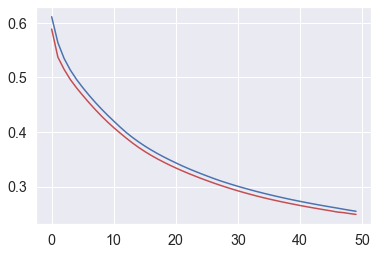

In [14]:
from turtle import color
history = ANN1.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [15]:
ANN2_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.107527,0.107527,0.105925,0.105925,0.105925,0.106566
MAE:,0.107527,0.107527,0.105925,0.105925,0.105925,0.106566
R^2:,-0.120482,-0.120482,-0.118474,-0.118474,-0.118474,-0.119277
roc_auc:,0.892671,0.835659,0.882394,0.872065,0.867402,0.870038
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.503749,0.485303,inf,0.488683,0.471472,inf


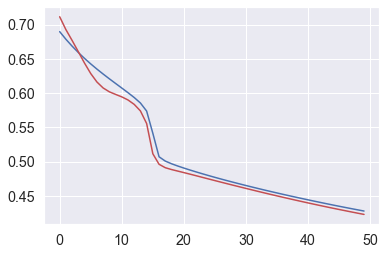

In [16]:
from turtle import color
history = ANN2.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [17]:
ANN3_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.011434,0.011434,0.011437,0.011437,0.011437,0.011436
MAE:,0.011434,0.011434,0.011437,0.011437,0.011437,0.011436
R^2:,-0.011566,-0.011566,-0.011570,-0.011570,-0.011570,-0.011568
roc_auc:,0.915594,0.835379,0.912686,0.891157,0.936624,0.898288
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.404307,inf,0.391819,0.407514,0.428711,inf


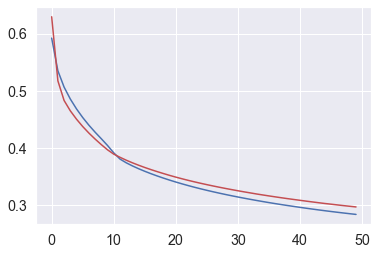

In [18]:
from turtle import color
history = ANN3.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [19]:
ANN4_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.069159,0.069159,0.069159,0.069159,0.069159,0.069159
MAE:,0.069159,0.069159,0.069159,0.069159,0.069159,0.069159
R^2:,-0.074297,-0.074297,-0.074297,-0.074297,-0.074297,-0.074297
roc_auc:,0.941631,0.933301,0.861283,0.461576,0.871784,0.813915
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,inf,0.544065,0.628422,0.802203,0.489740,inf


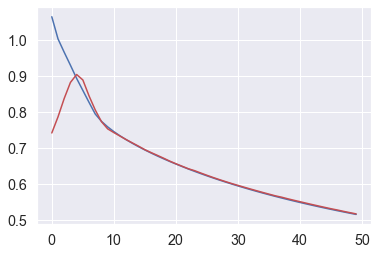

In [20]:
from turtle import color
history = ANN4.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

## Inference

In [21]:
def propensity_score_functANN(dataset,model,dataset2,dehwab):
    
    dataset2.columns = dataset2.columns.str.strip() 
    
    if dehwab == True: 
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re74','re75','re78']]
    else:
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re75','re78']]

    treat =  dataset.iloc[:,0]
    dataset =  dataset.iloc[:,1:len(dataset)]
    columns = dataset.columns
    dataset = dataset.to_numpy()
    dataset = dataset.astype(np.float32)
    #Y1 = np.reshape(Y1,(Y1.shape[0],1))
    # Generate propensity score prediction  
    probabilities = model.predict_proba(dataset)
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities # propensity score 
    # merge prediction and existing dataset 
    dataset = pd.DataFrame(dataset)
    dataset.columns = columns
    #dataset_proba = pd.merge(dataset, ps, left_index=True, right_index=True)
    dataset_proba = pd.merge(dataset2, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={0:'propensity_score'}, inplace = True) # rename column
    dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    return dataset_proba

In [22]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
# predict propensity scores
nswCps_lalonde_ps_ANN = propensity_score_functANN(nswCps_lalonde_subset,ANN1,nswCps_lalonde,False)
nswPsid_lalonde_ps_ANN= propensity_score_functANN(nswPsid_lalonde_subset,ANN2,nswPsid_lalonde,False)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_ANN = propensity_score_functANN(nswCps_dehWab_subset,ANN3,nswCps_dehWab,True)
nswPsid_dehWab_ps_ANN = propensity_score_functANN(nswPsid_dehWab_subset,ANN4,nswPsid_dehWab,True)

In [23]:
nswPsid_lalonde_ps_ANN

,treat,age,education*,black,hispanic,married,nodegree,re75,re78,propensity_score,propensity_logit
0,1.0,37,11,1.0,0.0,1.0,1.0,0,9930,0.271427,-0.987395
1,1.0,22,9,0.0,1.0,0.0,1.0,0,3595,0.696632,0.831311
2,1.0,30,12,1.0,0.0,0.0,0.0,0,24909,0.059114,-2.767346
3,1.0,27,11,1.0,0.0,0.0,1.0,0,7506,0.955577,3.068568
4,1.0,33,8,1.0,0.0,0.0,1.0,0,289,0.312067,-0.790472
...,...,...,...,...,...,...,...,...,...,...,...
2782,0.0,47,8,0.0,0.0,1.0,1.0,33837,38568,0.224749,-1.238200
2783,0.0,32,8,0.0,0.0,1.0,1.0,67137,59109,0.710253,0.896611
2784,0.0,47,10,0.0,0.0,1.0,1.0,47968,55710,0.362199,-0.565831
2785,0.0,54,0,0.0,1.0,1.0,1.0,44220,20540,0.221335,-1.257901


In [24]:
# save unmatched boost datasets 
nswCps_lalonde_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/ann/unmatched/nswCps_lalonde_ps_unmatched_ANN_FS1.csv')
nswPsid_lalonde_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/ann/unmatched/nswPsid_lalonde_ps_unmatched_ANN_FS1.csv')
nswCps_dehWab_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/ann/unmatched/nswCps_dehWab_ps_unmatched_ANN_FS1.csv')
nswPsid_dehWab_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/ann/unmatched/nswPsid_dehWab_ps_unmatched_ANN_FS1.csv')

## Bar plots of model performance

In [25]:
# Average accuracy
from tueplots import axes, bundles , figsizes, fonts,fontsizes
nsw_cps_lalonde_acc = [ANN1_metrics.loc['Accuracy:','avg'],boost1_metrics.loc['Accuracy:','avg'],forest1_metrics.loc['Accuracy:','avg'],cart1_metrics.loc['Accuracy:','avg'],logit1_metrics.loc['Accuracy:','avg']]
nsw_psid_lalonde_acc = [ANN2_metrics.loc['Accuracy:','avg'],boost2_metrics.loc['Accuracy:','avg'],forest2_metrics.loc['Accuracy:','avg'],cart2_metrics.loc['Accuracy:','avg'],logit2_metrics.loc['Accuracy:','avg']]
nsw_cps_dehWab_acc = [ANN3_metrics.loc['Accuracy:','avg'],boost3_metrics.loc['Accuracy:','avg'],forest3_metrics.loc['Accuracy:','avg'],cart3_metrics.loc['Accuracy:','avg'],logit3_metrics.loc['Accuracy:','avg']]
nsw_psid_dehWab_acc = [ANN4_metrics.loc['Accuracy:','avg'],boost4_metrics.loc['Accuracy:','avg'],forest4_metrics.loc['Accuracy:','avg'],cart4_metrics.loc['Accuracy:','avg'],logit4_metrics.loc['Accuracy:','avg']]

# Average precison
nsw_cps_lalonde_prec = [ANN1_metrics.loc['Precision:','avg'],boost1_metrics.loc['Precision:','avg'],forest1_metrics.loc['Precision:','avg'],cart1_metrics.loc['Precision:','avg'],logit1_metrics.loc['Precision:','avg']]
nsw_psid_lalonde_prec = [ANN2_metrics.loc['Precision:','avg'],boost2_metrics.loc['Precision:','avg'],forest2_metrics.loc['Precision:','avg'],cart2_metrics.loc['Precision:','avg'],logit2_metrics.loc['Precision:','avg']]
nsw_cps_dehWab_prec = [ANN3_metrics.loc['Precision:','avg'],boost3_metrics.loc['Precision:','avg'],forest3_metrics.loc['Precision:','avg'],cart3_metrics.loc['Precision:','avg'],logit3_metrics.loc['Precision:','avg']]
nsw_psid_dehWab_prec = [ANN4_metrics.loc['Precision:','avg'],boost4_metrics.loc['Precision:','avg'],forest4_metrics.loc['Precision:','avg'],cart4_metrics.loc['Precision:','avg'],logit4_metrics.loc['Precision:','avg']]

# Average recall 
nsw_cps_lalonde_rec = [ANN1_metrics.loc['Recall:','avg'],boost1_metrics.loc['Recall:','avg'],forest1_metrics.loc['Recall:','avg'],cart1_metrics.loc['Recall:','avg'],logit1_metrics.loc['Recall:','avg']]
nsw_psid_lalonde_rec = [ANN2_metrics.loc['Recall:','avg'],boost2_metrics.loc['Recall:','avg'],forest2_metrics.loc['Recall:','avg'],cart2_metrics.loc['Recall:','avg'],logit2_metrics.loc['Recall:','avg']]
nsw_cps_dehWab_rec = [ANN3_metrics.loc['Recall:','avg'],boost3_metrics.loc['Recall:','avg'],forest3_metrics.loc['Recall:','avg'],cart3_metrics.loc['Recall:','avg'],logit3_metrics.loc['Recall:','avg']]
nsw_psid_dehWab_rec = [ANN4_metrics.loc['Recall:','avg'],boost4_metrics.loc['Recall:','avg'],forest4_metrics.loc['Recall:','avg'],cart4_metrics.loc['Recall:','avg'],logit4_metrics.loc['Recall:','avg']]

# Average F1 
nsw_cps_lalonde_f1 = [ANN1_metrics.loc['F1:','avg'],boost1_metrics.loc['F1:','avg'],forest1_metrics.loc['F1:','avg'],cart1_metrics.loc['F1:','avg'],logit1_metrics.loc['F1:','avg']]
nsw_psid_lalonde_f1 = [ANN2_metrics.loc['F1:','avg'],boost2_metrics.loc['F1:','avg'],forest2_metrics.loc['F1:','avg'],cart2_metrics.loc['F1:','avg'],logit2_metrics.loc['F1:','avg']]
nsw_cps_dehWab_f1 = [ANN3_metrics.loc['F1:','avg'],boost3_metrics.loc['F1:','avg'],forest3_metrics.loc['F1:','avg'],cart3_metrics.loc['F1:','avg'],logit3_metrics.loc['F1:','avg']]
nsw_psid_dehWab_f1 = [ANN4_metrics.loc['F1:','avg'],boost4_metrics.loc['F1:','avg'],forest4_metrics.loc['F1:','avg'],cart4_metrics.loc['F1:','avg'],logit4_metrics.loc['F1:','avg']]

# Average log loss
nsw_cps_lalonde_logloss = [ANN1_metrics.loc['logloss:','avg'],boost1_metrics.loc['log-loss:','avg'],forest1_metrics.loc['log-loss:','avg'],cart1_metrics.loc['log-loss:','avg'],logit1_metrics.loc['log-loss:','avg']]
nsw_psid_lalonde_logloss = [ANN2_metrics.loc['logloss:','avg'],boost2_metrics.loc['log-loss:','avg'],forest2_metrics.loc['log-loss:','avg'],cart2_metrics.loc['log-loss:','avg'],logit2_metrics.loc['log-loss:','avg']]
nsw_cps_dehWab_logloss = [ANN3_metrics.loc['logloss:','avg'],boost3_metrics.loc['log-loss:','avg'],forest3_metrics.loc['log-loss:','avg'],cart3_metrics.loc['log-loss:','avg'],logit3_metrics.loc['log-loss:','avg']]
nsw_psid_dehWab_logloss = [ANN4_metrics.loc['logloss:','avg'],boost4_metrics.loc['log-loss:','avg'],forest4_metrics.loc['log-loss:','avg'],cart4_metrics.loc['log-loss:','avg'],logit4_metrics.loc['log-loss:','avg']]

# Average Roc Auc 
nsw_cps_lalonde_rocauc = [ANN1_metrics.loc['roc_auc:','avg'],boost1_metrics.loc['roc_auc:','avg'],forest1_metrics.loc['roc_auc:','avg'],cart1_metrics.loc['roc_auc:','avg'],logit1_metrics.loc['roc_auc:','avg']]
nsw_psid_lalonde_rocauc = [ANN2_metrics.loc['roc_auc:','avg'],boost2_metrics.loc['roc_auc:','avg'],forest2_metrics.loc['roc_auc:','avg'],cart2_metrics.loc['roc_auc:','avg'],logit2_metrics.loc['roc_auc:','avg']]
nsw_cps_dehWab_rocauc = [ANN3_metrics.loc['roc_auc:','avg'],boost3_metrics.loc['roc_auc:','avg'],forest3_metrics.loc['roc_auc:','avg'],cart3_metrics.loc['roc_auc:','avg'],logit3_metrics.loc['roc_auc:','avg']]
nsw_psid_dehWab_rocauc = [ANN4_metrics.loc['roc_auc:','avg'],boost4_metrics.loc['roc_auc:','avg'],forest4_metrics.loc['roc_auc:','avg'],cart4_metrics.loc['roc_auc:','avg'],logit4_metrics.loc['roc_auc:','avg']]

NameError: name 'boost1_metrics' is not defined

NameError: name 'nsw_cps_lalonde_acc' is not defined

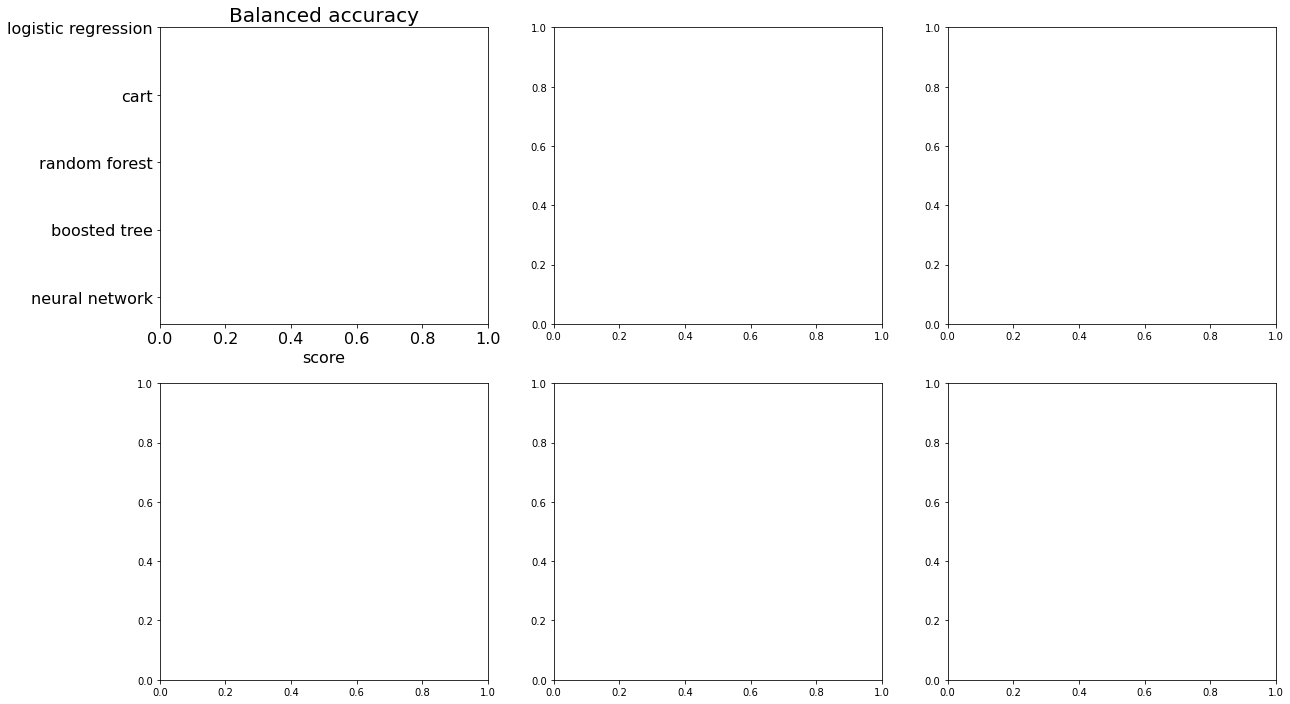

In [ ]:
# Create plot 
# Update plot paramaters 
fig, ax = plt.subplots(nrows=2, ncols=3,figsize = (20,12))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 300}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=2, ncols=3))
plt.rcParams.update({'font.size': 18})
y = np.arange(5)
x = np.arange(1)
width = 0.2
# Balanced accuracy

ax[0,0].set_title("Balanced accuracy",fontsize=20)
ax[0,0].set_xlabel('score',fontsize=16)
ax[0,0].set_yticks(y+2*width, ['neural network', 'boosted tree', 'random forest', 'cart', 'logistic regression'],fontsize=16)
ax[0,0].tick_params(axis='x', which='major', labelsize=16)

colour1 = "#E31B23" # CPS lalonde
colour2 = "#e31b8c" # PSID lalonde
colour3 = "#003366" # CPS dehwab
colour4 = "#006614" # PSID dehwab

ax[0,0].barh(y,nsw_cps_lalonde_acc,width,color = colour1)
ax[0,0].barh(y+width,nsw_psid_lalonde_acc,width,color = colour2)
ax[0,0].barh(y+2*width,nsw_cps_dehWab_acc,width,color = colour3)
ax[0,0].barh(y+(3*width),nsw_psid_dehWab_acc,width,color = colour4)

ax[0,0].set_facecolor('white')
ax[0,0].grid(color='white', axis='y')
ax[0,0].grid(color='white', axis='x')
ax[0,0].spines['left']
ax[0,0].spines['right']
ax[0,0].spines['bottom']
ax[0,0].tick_params(right='on')
ax[0,0].tick_params(left='on')
ax[0,0].tick_params(bottom='on')

# precision

ax[0,1].set_title("precision",fontsize=20)
ax[0,1].set_xlabel('score',fontsize=16)
ax[0,1].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[0,1].tick_params(axis='x', which='major', labelsize=16)

ax[0,1].barh(y,nsw_cps_lalonde_prec,width,color = colour1)
ax[0,1].barh(y+width,nsw_psid_lalonde_prec,width,color = colour2)
ax[0,1].barh(y+2*width,nsw_cps_dehWab_prec,width,color = colour3)
ax[0,1].barh(y+(3*width),nsw_psid_dehWab_prec,width,color = colour4)

ax[0,1].set_facecolor('white')
ax[0,1].grid(color='white', axis='y')
ax[0,1].grid(color='white', axis='x')
ax[0,1].spines['left']
ax[0,1].spines['right']
ax[0,1].spines['bottom']
ax[0,1].tick_params(right='on')
ax[0,1].tick_params(left='on')
ax[0,1].tick_params(bottom='on')

# recall 

ax[0,2].set_title("Recall",fontsize=20)
ax[0,2].set_xlabel('score',fontsize=16)
ax[0,2].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[0,2].tick_params(axis='x', which='major', labelsize=16)

ax[0,2].barh(y,nsw_cps_lalonde_rec,width,color = colour1)
ax[0,2].barh(y+width,nsw_psid_lalonde_rec,width,color = colour2)
ax[0,2].barh(y+2*width,nsw_cps_dehWab_rec,width,color = colour3)
ax[0,2].barh(y+(3*width),nsw_psid_dehWab_rec,width,color = colour4)

ax[0,2].set_facecolor('white')
ax[0,2].grid(color='white', axis='y')
ax[0,2].grid(color='white', axis='x')
ax[0,2].spines['left']
ax[0,2].spines['right']
ax[0,2].spines['bottom']
ax[0,2].tick_params(right='on')
ax[0,2].tick_params(left='on')
ax[0,2].tick_params(bottom='on')

# F1
ax[1,0].set_title("F1 score",fontsize=20)
ax[1,0].set_xlabel('score',fontsize=16)
ax[1,0].set_yticks(y+2*width, ['neural network', 'boosted tree', 'random forest', 'cart', 'logistic regression'],fontsize=16)
ax[1,0].tick_params(axis='x', which='major', labelsize=16)

ax[1,0].barh(y,nsw_cps_lalonde_f1,width,color = colour1)
ax[1,0].barh(y+width,nsw_psid_lalonde_f1,width,color = colour2)
ax[1,0].barh(y+2*width,nsw_cps_dehWab_f1,width,color = colour3)
ax[1,0].barh(y+(3*width),nsw_psid_dehWab_f1,width,color = colour4)

ax[1,0].set_facecolor('white')
ax[1,0].grid(color='white', axis='y')
ax[1,0].grid(color='white', axis='x')
ax[1,0].spines['left']
ax[1,0].spines['right']
ax[1,0].spines['bottom']
ax[1,0].tick_params(right='on')
ax[1,0].tick_params(left='on')
ax[1,0].tick_params(bottom='on')


# Log loss
ax[1,1].set_title("Log loss",fontsize=20)
ax[1,1].set_xlabel('score',fontsize=16)
ax[1,1].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[1,1].tick_params(axis='x', which='major', labelsize=16)

ax[1,1].barh(y,nsw_cps_lalonde_logloss,width,color = colour1)
ax[1,1].barh(y+width,nsw_psid_lalonde_logloss,width,color = colour2)
ax[1,1].barh(y+2*width,nsw_cps_dehWab_logloss,width,color = colour3)
ax[1,1].barh(y+(3*width),nsw_psid_dehWab_logloss,width,color = colour4)

ax[1,1].set_facecolor('white')
ax[1,1].grid(color='white', axis='y')
ax[1,1].grid(color='white', axis='x')
ax[1,1].spines['left']
ax[1,1].spines['right']
ax[1,1].spines['bottom']
ax[1,1].tick_params(right='on')
ax[1,1].tick_params(left='on')
ax[1,1].tick_params(bottom='on')

# Roc-AUC
ax[1,2].set_title("Roc-Auc",fontsize=20)
ax[1,2].set_xlabel('score',fontsize=16)
ax[1,2].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[1,2].tick_params(axis='x', which='major', labelsize=16)

ax[1,2].barh(y,nsw_cps_lalonde_rocauc,width,color = colour1)
ax[1,2].barh(y+width,nsw_psid_lalonde_rocauc,width,color = colour2)
ax[1,2].barh(y+2*width,nsw_cps_dehWab_rocauc,width,color = colour3)
ax[1,2].barh(y+(3*width),nsw_psid_dehWab_rocauc,width,color = colour4)

ax[1,2].set_facecolor('white')
ax[1,2].grid(color='white', axis='y')
ax[1,2].grid(color='white', axis='x')
ax[1,2].spines['left']
ax[1,2].spines['right']
ax[1,2].spines['bottom']
ax[1,2].tick_params(right='on')
ax[1,2].tick_params(left='on')
ax[1,2].tick_params(bottom='on')

labels = ['CPS - Lalonde','PSID - Lalonde','CPS - DW','PSID - DW']
fig.legend(labels, loc='lower center', bbox_to_anchor=(0.5,-0.1), ncol=len(labels),markerscale=3, bbox_transform=fig.transFigure,prop={'size': 18})

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/fig8_training_evaluation_averages.png', bbox_inches='tight')
plt.show()

### Analysis on model outptus - Probability calibration curves 

In [ ]:
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

In [ ]:
from sklearn import tree      
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier    


# Take a random sample from the data with an even number of treated and control for testing

nswCps_lalonde_valid = nswCps_lalonde.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswCps_lalonde = nswCps_lalonde.drop(nswCps_lalonde_valid.index) # Remove all samples from training which are in the sample 

nswPsid_lalonde_valid = nswPsid_lalonde.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswPsid_lalonde = nswPsid_lalonde.drop(nswPsid_lalonde_valid.index) # Remove all samples from training which are in the sample 

nswCps_dehWab_valid = nswCps_dehWab.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswCps_dehWab = nswCps_dehWab.drop(nswCps_dehWab_valid.index)# Remove all samples from training which are in the sample 

nswPsid_Dehwab_valid = nswPsid_dehWab.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswPsid_dehWab = nswPsid_dehWab.drop(nswPsid_Dehwab_valid.index) # Remove all samples from training which are in the sample 

# covariates used in each mdoel 
logit_vars = ['treat','age','agesq','education*','educsq','black','hispanic','married','nodegree','re75','u75','educ_re75']
logit_vars2 = ['treat','age','agesq','education*','educsq','black','hispanic','married','nodegree','re74','re75','u74','u75','educ_re75']
tree_vars = ['treat','age','education*','black','hispanic','married','nodegree','re75']
tree_vars2 = ['treat','age','education*','black','hispanic','married','nodegree','re74','re75']
ann_vars = ['treat','ageboxcox','black','hispanic','married','nodegree','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12', 'education_13','education_14', 'education_15', 'education_16', 'education_17']
ann_vars2 = ['treat','ageboxcox','black','hispanic','married','nodegree','lnre74','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12',  'education_13', 'education_14', 'education_15', 'education_16', 'education_17']
continuos_vars = ['ageboxcox','lnre75'] 
continuos_vars2= ['ageboxcox','lnre74','lnre75'] 
# ======== Lalonde - sample ======== #

# ~~~~~~~~~~
# 1 cps
# ~~~~~~~~~~

#logit model 
cps_lalonde_subset_logit = nswCps_lalonde[logit_vars]
cps_lalonde_subset_valid_logit = nswCps_lalonde_valid[logit_vars]
#decision tree models 
cps_lalonde_subset_trees = nswCps_lalonde[tree_vars]
cps_lalonde_subset_valid_trees = nswCps_lalonde_valid[tree_vars]
#ann model 
cps_lalonde_subset_ann = nswCps_lalonde[ann_vars]
cps_lalonde_subset_valid_ann = nswCps_lalonde_valid[ann_vars]
cps_lalonde_subset_ann[continuos_vars] = sc.fit_transform(cps_lalonde_subset_ann[continuos_vars])
cps_lalonde_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_lalonde_subset_valid_ann[continuos_vars])

# ~~~~~~~~~~
# 2 PSID 
# ~~~~~~~~~~

#logit model 
psid_lalonde_subset_logit = nswPsid_lalonde[logit_vars]
psid_lalonde_subset_valid_logit = nswPsid_lalonde_valid[logit_vars]
#decision tree models 
psid_lalonde_subset_trees = nswPsid_lalonde[tree_vars]
psid_lalonde_subset_valid_trees = nswPsid_lalonde_valid[tree_vars]
#ann model 
psid_lalonde_subset_ann = nswPsid_lalonde[ann_vars]
psid_lalonde_subset_valid_ann = nswPsid_lalonde_valid[ann_vars]
psid_lalonde_subset_ann[continuos_vars] = sc.fit_transform(psid_lalonde_subset_ann[continuos_vars])
psid_lalonde_subset_valid_ann[continuos_vars] = sc.fit_transform(psid_lalonde_subset_valid_ann[continuos_vars])


# ======== Dehejia - Wahba sample ======== #

# ~~~~~~~~~~
# 3 CPS
# ~~~~~~~~~~
# logit 
cps_dehWab_subset_logit = nswCps_dehWab[logit_vars2]
cps_dehWab_subset_valid_logit = nswCps_dehWab_valid[logit_vars2]
# decision tree's
cps_dehWab_subset_trees = nswCps_dehWab[tree_vars2]
cps_dehWab_subset_valid_trees = nswCps_dehWab_valid[tree_vars2]
#ann
cps_dehWab_subset_ann = nswCps_dehWab[ann_vars2]
cps_dehWab_subset_valid_ann = nswCps_dehWab_valid[ann_vars2]
cps_dehWab_subset_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_ann[continuos_vars])
cps_dehWab_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_valid_ann[continuos_vars])

# ~~~~~~~~~~
# 4 PSID
# ~~~~~~~~~~
# logit 
psid_dehWab_subset_logit = nswCps_dehWab[logit_vars2]
psid_dehWab_subset_valid_logit = nswCps_dehWab_valid[logit_vars2]
# decision tree's
psid_dehWab_subset_trees = nswCps_dehWab[tree_vars2]
psid_dehWab_subset_valid_trees = nswCps_dehWab_valid[tree_vars2]
#ann
psid_dehWab_subset_ann = nswCps_dehWab[ann_vars2]
psid_dehWab_subset_valid_ann = nswCps_dehWab_valid[ann_vars2]
psid_dehWab_subset_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_ann[continuos_vars])
psid_dehWab_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_valid_ann[continuos_vars])

# Function to run all models and get a prediction - using the best features from our grid search 
# Inputs are the dataset's we want to look at 


def fit_and_predict_all_models(logit_data,logit_valid,tree_data,tree_valid,ann_data,ann_valid,neuralnet):
    
    '''
    could make this function do all the smote and rejoing the validation set again sincce i am making my own, so there are more training examples
    
    '''
   
  
    
    #Train test split 
    def return_trainTest_split(Dataset):
        # shuffle data
        Dataset = Dataset.sample(frac = 1,random_state=0)
        Features = Dataset.drop('treat', axis=1)
        Target = Dataset['treat']
        X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size=0.3, shuffle=True)
        return X_train, X_test, y_train, y_test;

    
    resample=SMOTEENN(random_state=0) # resampling
    
    '''
    '''
    
    # Logit
    
    X_train1, X_test1, y_train1, y_test1 = return_trainTest_split(logit_data)
    X_train1, y_train1 = resample.fit_resample(X_train1, y_train1)	
    
    shuffled = pd.concat([pd.DataFrame(X_train1),pd.DataFrame(y_train1)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
    X_train1, y_train1 = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
    
    logit_demo = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
    
    logit_demo.fit(X_train1,y_train1)
    
    logit_valid = logit_valid.sample(frac = 1,random_state=0)
    X_test1 = logit_valid.drop('treat',axis=1, inplace = False)
    y_test1 = logit_valid['treat']
    
    predicted_proba_logit = logit_demo.predict_proba(X_test1)
    
    
    
    # Decision tree models 
    
    X_train2, X_test2, y_train2, y_test2 = return_trainTest_split(tree_data)

    X_train2, y_train2 = resample.fit_resample(X_train2, y_train2)	
    shuffled = pd.concat([pd.DataFrame(X_train2),pd.DataFrame(y_train2)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
    X_train2, y_train2 = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]

    tree_valid = tree_valid.sample(frac = 1,random_state=0)
    X_test2 = tree_valid.drop('treat',axis=1, inplace = False)
    y_test2 = tree_valid['treat']

    # Cart
    
    CART_demo = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 5, max_leaf_nodes=12,min_samples_leaf=2)
    CART_demo.fit(X_train2,y_train2)
    predicted_proba_cart = CART_demo.predict_proba(X_test2)
    #RF
    forest_demo = RandomForestClassifier(random_state=0,criterion='entropy',max_depth=8,max_features='auto',min_samples_split=3,n_estimators=500)
    forest_demo.fit(X_train2,y_train2)
    predicted_proba_forest = forest_demo.predict_proba(X_test2)
    #boost
    boost_demo = XGBClassifier(objective= 'binary:logistic',booser='dart',colsample_bytree=0.3,gamma=0.5,learning_rate=0.05,mind_child_weight=1,subsample=0.5,seed=0,nthread=4)  
    boost_demo.fit(X_train2,y_train2)
    predicted_proba_boost = boost_demo.predict_proba(X_test2)

    #ANN
    X_train3, X_test3, y_train3, y_test3 = return_trainTest_split(ann_data)
    X_train3, y_train3 = resample.fit_resample(X_train3, y_train3)	
    shuffled = pd.concat([pd.DataFrame(X_train3),pd.DataFrame(y_train3)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
    X_train3, y_train3 = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]

    ann_valid = ann_valid.sample(frac = 1,random_state=0)
    X_test3 = ann_valid.drop('treat',axis=1, inplace = False)
    y_test3 = ann_valid['treat']

    Epochs = 100
    learning_rate = 0.0001
    weight_decay = 0.05
    batch_size = 256

    X_train3 = X_train3.to_numpy()
    y_train3 = y_train3.to_numpy()
    X_train3 = X_train3.astype(np.float32)
    y_train3 = y_train3.astype(np.float32)
    y_train3 = np.reshape(y_train3,(y_train3.shape[0],1))

    X_test3 = X_test3.to_numpy()
    y_test3 = y_test3.to_numpy()
    X_test3 = X_test3.astype(np.float32)
    y_test3 = y_test3.astype(np.float32)
    y_test3 = np.reshape(y_test3,(y_test3.shape[0],1))

    ann_demo = NeuralNetClassifier(neuralnet,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size =batch_size,optimizer = optim.Adam,criterion = nn.BCELoss,iterator_valid__shuffle=False,verbose=0 )

    ann_demo.fit(X_train3,y_train3)
    predicted_proba_ANN = ann_demo.predict_proba(X_test3)
    
    return predicted_proba_logit,predicted_proba_cart,predicted_proba_forest,predicted_proba_boost,predicted_proba_ANN,y_test1,y_test2,y_test3;

    
    

logit_proba1,cart_proba1,forest_proba1,boost_proba1,ann_proba1,yl1,yt1,ya1 = fit_and_predict_all_models(cps_lalonde_subset_logit,
                                                                                            cps_lalonde_subset_valid_logit,
                                                                                            cps_lalonde_subset_trees,
                                                                                            cps_lalonde_subset_valid_trees,
                                                                                            cps_lalonde_subset_ann,
                                                                                            cps_lalonde_subset_valid_ann,
                                                                                            twoLayerNN1)

logit_proba2,cart_proba2,forest_proba2,boost_proba2,ann_proba2,yl2,yt2,ya2 = fit_and_predict_all_models(psid_lalonde_subset_logit,
                                                                                            psid_lalonde_subset_valid_logit,
                                                                                            psid_lalonde_subset_trees,
                                                                                            psid_lalonde_subset_valid_trees,
                                                                                            psid_lalonde_subset_ann,
                                                                                            psid_lalonde_subset_valid_ann,
                                                                                            twoLayerNN1)

logit_proba3,cart_proba3,forest_proba3,boost_proba3,ann_proba3,yl3,yt3,ya3 = fit_and_predict_all_models(cps_dehWab_subset_logit,
                                                                                            cps_dehWab_subset_valid_logit,
                                                                                            cps_dehWab_subset_trees,
                                                                                            cps_dehWab_subset_valid_trees,
                                                                                            cps_dehWab_subset_ann,
                                                                                            cps_dehWab_subset_valid_ann,
                                                                                            twoLayerNN2)

logit_proba4,cart_proba4,forest_proba4,boost_proba4,ann_proba4,yl4,yt4,ya4 = fit_and_predict_all_models(psid_dehWab_subset_logit,
                                                                                            psid_dehWab_subset_valid_logit,
                                                                                            psid_dehWab_subset_trees,
                                                                                            psid_dehWab_subset_valid_trees,
                                                                                            psid_dehWab_subset_ann,
                                                                                            psid_dehWab_subset_valid_ann,
                                                                                            twoLayerNN2)

# Calibration curve for each models prediction 
from sklearn.calibration import calibration_curve
logit_fop1  , logit_mpv1  = calibration_curve(yl1, logit_proba1[:,1], n_bins=10, normalize=True)
cart_fop1   , cart_mpv1   = calibration_curve(yt1, cart_proba1[:,1], n_bins=10, normalize=True)
forest_fop1  , forest_mpv1 = calibration_curve(yt1, forest_proba1[:,1], n_bins=10, normalize=True)
boost_fop1  , boost_mpv1  = calibration_curve(yt1, boost_proba1[:,1], n_bins=10, normalize=True)
ann_fop1    , ann_mpv1    = calibration_curve(ya1, ann_proba1, n_bins=10, normalize=True)

logit_fop2  , logit_mpv2  = calibration_curve(yl2, logit_proba2[:,1], n_bins=10, normalize=True)
cart_fop2   , cart_mpv2   = calibration_curve(yt2, cart_proba2[:,1], n_bins=10, normalize=True)
forest_fop2  , forest_mpv2 = calibration_curve(yt2, forest_proba2[:,1], n_bins=10, normalize=True)
boost_fop2  , boost_mpv2  = calibration_curve(yt2, boost_proba2[:,1], n_bins=10, normalize=True)
ann_fop2    , ann_mpv2    = calibration_curve(ya2, ann_proba2, n_bins=10, normalize=True)

logit_fop3  , logit_mpv3  = calibration_curve(yl3, logit_proba3[:,1], n_bins=10, normalize=True)
cart_fop3   , cart_mpv3   = calibration_curve(yt3, cart_proba3[:,1], n_bins=10, normalize=True)
forest_fop3  , forest_mpv3 = calibration_curve(yt3, forest_proba3[:,1], n_bins=10, normalize=True)
boost_fop3  , boost_mpv3  = calibration_curve(yt3, boost_proba3[:,1], n_bins=10, normalize=True)
ann_fop3    , ann_mpv3    = calibration_curve(ya3, ann_proba3, n_bins=10, normalize=True)

logit_fop4  , logit_mpv4  = calibration_curve(yl4, logit_proba4[:,1], n_bins=10, normalize=True)
cart_fop4   , cart_mpv4   = calibration_curve(yt4, cart_proba4[:,1], n_bins=10, normalize=True)
forest_fop4  , forest_mpv4 = calibration_curve(yt4, forest_proba4[:,1], n_bins=10, normalize=True)
boost_fop4  , boost_mpv4  = calibration_curve(yt4, boost_proba4[:,1], n_bins=10, normalize=True)
ann_fop4    , ann_mpv4    = calibration_curve(ya4, ann_proba4, n_bins=10, normalize=True)


import scipy.stats as stat
import pylab 
from tueplots import axes, bundles , figsizes, fonts,fontsizes

fig, ax = plt.subplots(nrows=2, ncols=2,figsize = (8,6))

plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(axes.lines())


ax[0,0].grid(color='white', axis='x')
ax[0,0].grid(color='white', axis='y')
ax[0,1].grid(color='white', axis='x')
ax[0,1].grid(color='white', axis='y')
ax[1,0].grid(color='white', axis='x')
ax[1,0].grid(color='white', axis='y')
ax[1,1].grid(color='white', axis='x')
ax[1,1].grid(color='white', axis='y')


marker = 's'
linewidth = 1
marker_size = 3

ax[0,0].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=1,color='black')
ax[0,0].plot(logit_mpv1  , logit_fop1 , marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size)
ax[0,0].plot(cart_mpv1   , cart_fop1, marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size)
ax[0,0].plot(forest_mpv1 , forest_fop1,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size)
ax[0,0].plot(boost_mpv1  , boost_fop1,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size)
ax[0,0].plot(ann_mpv1    , ann_fop1 ,marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size)
ax[0,0].set_xlabel('Mean predicted value')
ax[0,0].set_ylabel('Fraction of positives')

ax[0,1].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=1,color='black')
ax[0,1].plot(logit_mpv2  , logit_fop2 , marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size)
ax[0,1].plot(cart_mpv2   , cart_fop2  , marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size)
ax[0,1].plot(forest_mpv2 , forest_fop2 ,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size)
ax[0,1].plot(boost_mpv2  , boost_fop2  ,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size)
ax[0,1].plot(ann_mpv2    , ann_fop2    , marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size)
ax[0,1].set_xlabel('Mean predicted value')
ax[0,1].set_ylabel('Fraction of positives')

ax[1,0].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=1,color='black')
ax[1,0].plot(logit_mpv3  , logit_fop3  ,marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size)
ax[1,0].plot(cart_mpv3   , cart_fop3   ,marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size)
ax[1,0].plot(forest_mpv3 , forest_fop3 ,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size)
ax[1,0].plot(boost_mpv3  , boost_fop3  ,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size)
ax[1,0].plot(ann_mpv3    , ann_fop3    , marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size)
ax[1,0].set_xlabel('Mean predicted value')
ax[1,0].set_ylabel('Fraction of positives')

ax[1,1].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=linewidth,color='black')
ax[1,1].plot(logit_mpv4  , logit_fop4  ,marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size)
ax[1,1].plot(cart_mpv4   , cart_fop4   ,marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size)
ax[1,1].plot(forest_mpv4 , forest_fop4 ,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size)
ax[1,1].plot(boost_mpv4  , boost_fop4  ,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size)
ax[1,1].plot(ann_mpv4    , ann_fop4    , marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size)
ax[1,1].set_xlabel('Mean predicted value')
ax[1,1].set_ylabel('Fraction of positives')


plt.legend(loc=(1.04, 0.1))
plt.show()

## Box plots

# Box plots of estimated propensity scores across each model - CPS group 

fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022())
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}


treated_propensity_PS = logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==1]

Logit_Cpscomprison_PS = logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==0]
Logit_Psidcomprison_PS = logitNswPsid_lalonde['propensity_score'][logitNswPsid_lalonde['treat']==0]

cart_Cpscomprison_PS = cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==0]
cart_Psidcomprison_PS = cartNswPsid_lalonde['propensity_score'][cartNswPsid_lalonde['treat']==0]

ax.boxplot([treated_propensity_PS,Logit_Cpscomprison_PS,Logit_Psidcomprison_PS,cart_Cpscomprison_PS,cart_Psidcomprison_PS],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4,5],['Treated', 'Logit cps ','Logit psid','Cart  cps','Cart psid'])


ax.set_xlabel('Model')

ax.set_ylabel('Propensity score')

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/_boxplots.png', bbox_inches='tight')

plt.show()